
## Exploratory Data Analysis on Human Body Measurements using Python

### Initial Setup 

In [1]:
# Download basename and exists from OS module which will be used in the download function
from os.path import basename, exists

# Create a function named download_file, to dounload the scripts and files from Github to local path
def download_files(url):
    """
    Downloads the scripts/ files from Github to local directory
    takes url as input.
    """
    filename = basename(url)
    # Checking if the file exists in the local directory and it downloads the file if it doesn't exist already.
    if not exists(filename):
        from urllib.request import urlretrieve
        # Downloading the files to the local path
        local, _ = urlretrieve(url, filename)
        # Printing confirmation message
        print("Downloaded " + local)

In [2]:
#  Calling download functions to download .py files and data files used throughtout this project
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
import thinkplot
import thinkstats2
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import patsy
import statistics as st
from scipy import stats

In [4]:
# Source of the dataset:  https://www.key2stats.com/data-sets/listing
# This function will read the source dataset and load into dataframe
def create_orig_df():
    body_measures_orig = pd.read_csv(r'Body_measurements_Dataset.csv')
    return body_measures_orig

In [5]:
def cleanse_df(body_measures_orig):
    """
    This function will cleanse the dataframe body_measures
    Returns: Cleansed Dataframe
    """
    # taking a copy of the original data, which we will be working on henceforth
    body_measures_df=body_measures_orig.copy()
    # Removing the rows that nulls in the fields we will be working on the project 
    #body_measures_df=body_measures_df.dropna()
    body_measures_df=body_measures_df.dropna(subset=['bia_di','che_di','sho_gi','che_gi','wai_gi','age','hgt','wgt','sex','ank_gi','kne_gi'])
    body_measures_df = body_measures_df.reset_index()
    body_measures_df = body_measures_df.drop(['index'], axis=1)
    # Rounding off column values to 1 decimal point 
    for col in body_measures_df.columns:
        if col not in ("age","sex"):
           body_measures_df[col]= body_measures_df[col].round(decimals = 1)
    # Converting the values of the column age and sex as Integer
    body_measures_df = body_measures_df.astype({"age":"int","sex":"int"})
    body_measures_df=body_measures_df[body_measures_df.sex.isin([0,1])]
    body_measures_df=body_measures_df[['bia_di',
       'bii_di', 'bit_di', 'che_de', 'che_di', 'elb_di', 'wri_di', 'kne_di',
       'ank_di', 'sho_gi', 'che_gi', 'wai_gi', 'nav_gi', 'hip_gi', 'thi_gi',
       'bic_gi', 'for_gi', 'kne_gi', 'cal_gi', 'ank_gi', 'wri_gi',    'age',
          'wgt',    'hgt',    'sex']]
    return body_measures_df

In [6]:
def add_new_cols(body_measures_df):
    """
    This function will add new columns which will be further used in the project.
    body_measures_df: Input Dataframe
    returns dataframe with newly added columns
    """
    # Add a new column BMI based on the height and weight calculations
    body_measures_df['BMI']=(body_measures_df.wgt/body_measures_df.hgt/body_measures_df.hgt)*10000
    # Replace na with 0 if BMI is Null
    body_measures_df['BMI'].fillna(0,inplace=True)
    # Add new column BMI desciption that has values such as Underweight(BMI <18.5), Healthy( BMI between 18.5 to 25)
    # Overweight (BMI value between 25 and 30), Obese(BMI >30)
    body_measures_df['BMI_desc']=body_measures_df['BMI'].apply(lambda val:'Invalid value' if val==0 else 'Underweight' if val < 18.5 else 'Healthy' if val >= 18.5 and val < 25 else 'Overweight' if val >= 25 and val < 30 else 'Obese') 
    # Replace na with 0 if Age is Null
    body_measures_df['age'].fillna(0,inplace=True)
    # Add a new field Age category such as Child(Age <18), Young Adult(18<Age<30), Adult(30<Age<68), Senior(Age>68)
    body_measures_df['age_category']=body_measures_df['age'].apply(lambda val1:'Invalid Age' if val1==0 else 'Child' if val1 < 18 else 'Young Adult' if val1 >= 18 and val1 < 30 else 'Adult' if val1 >= 30 and val1 < 68 else 'Senior')
    return body_measures_df


In [7]:
def MakeOrigFrames():
    """
    This function will create body Measures dataframe, perform cleansing and add new columns
    Returns: body_measures_orig,body_measures_df
    """
    body_measures_orig=create_orig_df()
    body_measures_df=cleanse_df(body_measures_orig)
    body_measures_df=add_new_cols(body_measures_df)
    return body_measures_orig,body_measures_df


In [8]:
def assert_df(body_measures_df):
    """
    Takes body_measures_df as input and validates if the data loaded is accurate
    """
    assert len(body_measures_df) == 1341
    assert body_measures_df["bia_di"].max()== 50.4
    assert body_measures_df["hgt"].min() == 143.2
    assert len(body_measures_df[body_measures_df['BMI_desc'] == ("Healthy")]) == 715


In [9]:
# Calling MakeOrigFrames functions to create body measure dataframes
body_measures_orig,body_measures_df=MakeOrigFrames()
assert_df(body_measures_df)
#Excluding children in this project and only considering Adults and Young Adults for the study
body_measures_df=body_measures_df[body_measures_df.age_category.isin(['Adult','Young Adult'])]



In [10]:
body_measures_df.head()

,bia_di,bii_di,bit_di,che_de,che_di,elb_di,wri_di,kne_di,ank_di,sho_gi,...,cal_gi,ank_gi,wri_gi,age,wgt,hgt,sex,BMI,BMI_desc,age_category
0,37.9,29.0,32.9,18.6,27.0,12.7,10.6,18.2,12.1,109.5,...,37.0,21.8,15.8,22,72.0,163.0,0,27.099251,Overweight,Young Adult
1,38.8,25.4,29.5,19.8,31.1,11.5,11.1,18.4,14.1,92.3,...,34.4,22.1,14.9,31,77.4,187.3,1,22.063043,Healthy,Adult
2,38.7,33.3,33.8,20.9,30.2,14.0,10.5,18.9,14.8,108.9,...,36.4,24.5,16.0,29,81.8,182.9,0,24.452648,Healthy,Young Adult
3,41.5,29.1,33.0,20.8,24.6,14.7,10.0,17.7,14.0,106.1,...,31.6,19.5,17.1,46,64.9,175.8,0,20.999403,Healthy,Adult
5,40.5,25.7,32.6,18.1,26.8,14.2,10.9,18.7,14.9,113.7,...,37.3,20.0,15.8,30,73.6,200.4,0,18.326620,Underweight,Adult


### Question 1

#### ***Question:*** A minimum of 5 variables in your dataset used during your analysis (for help with selecting, the author made his selection on page 6 of your book). Consider what you think could have an impact on your question – remember this is never perfect, so don’t be worried if you miss one (Chapter 1).

#### ***Solution:*** Some of the variables used in this project from the dataset are Age, Height, Weight,BMI, sex, che_gi, wai_gi,sho_gi.  The reason these variables are chosen is because we are trying the below questions:
##### 1.Are Men healthier than women?
##### 2.Are Men heavier than Women?
##### 3.Are Men Taller than women in general?
##### 4.Do Men have broader shoulder than women?
##### 5.Are young Men & Women healthier than the Adults?

### Question 2

#### ***Question:*** Describe what the 5 variables mean in the dataset (Chapter 1).
##### ***Solution:*** 
##### *wri_gi* - A numerical vector, respondent's wrist minimum girth in centimeters, measured as average of right and left girths.
##### *age* - A numerical vector, respondent's age in years.
##### *wgt* - A numerical vector, respondent's weight in kilograms.
##### *hgt* - A numerical vector, respondent's height in centimeters.
##### *sex* - A categorical vector, 1 if the respondent is male, 0 if female.
##### *sho_gi* - A numerical vector, respondent's shoulder girth in centimeters, measured over deltoid muscles.
##### *che_gi* - A numerical vector, respondent's chest girth in centimeters, measured at nipple line in males and just above breast tissue in females, mid-expiration.
##### *wai_gi* - A numerical vector, respondent's waist girth in centimeters, measured at the narrowest part of torso below the rib cage as average of contracted and relaxed position.
##### *BMI* - A derived field from Height and Weight, represented in floating number

### Question 3

#### ***Question:*** Include a histogram of each of the 5 variables – in your summary and analysis, identify any outliers and explain the reasoning for them being outliers and how you believe they should be handled (Chapter 2).

In [11]:
def create_histograms(input_df,var,desc1,bins=10,outlier=True):
    """
    This function will create Histogram for the Variable and Plot it.
    input_df : The Dataframe in which the variable we are trying to plot exists
    var: The Variable that we are trying to plot the Histogram
    desc1: Description of the variable which will be used in the Title of Histogram
    bins: Size of the bins, default value is 10.
    outliers: A flag that indicates if data has Outliers or not. This will be further used in the Title
    """
    # Removing the Nulls from the column
    variab=input_df[var].dropna()
    # Plotting the Histogram  for the variable
    hist_var = np.histogram(variab,bins=bins)
    # Printing the Histogram values
    print(f"The Histogram of {var} is {hist_var}")
    plt.hist(variab, edgecolor='black')
    # The outlier flag is used to check if the data has Outliers which will be used in Title for display
    if outlier:
        plt.title(f'{desc1} of Participants(with Outliers)')
    else:
        plt.title(f'{desc1} of Participants')
    plt.xlabel(f'{desc1}')
    plt.ylabel('Frequency')
       

In [12]:
def remove_outliers(input_df,var):
    """
    This function removes outliers from the Input Variable.
    input_df, var: The Dataframe and the variable name for which we are trying to remove the outliers.
    Returns cleansed Dataframe
    """
    # Removing nulls from the field we are trying to remove the outliers.
    variab=input_df[var].dropna()
    # Plotting boxplot to indicate the outliers
    sns.boxplot(data=input_df,x=variab).set(title='Boxplot')
    # Computing First and Third quartile
    quart_25=variab.quantile(0.25)
    quart_75=variab.quantile(0.75)
    # Computing Inter Quartile as difference between first and Third quartile
    inter_quart=quart_75-quart_25
    print(f"The Inter Quartile range of {var} is {inter_quart}")
    # Computing the Lower and Upper whiskers to identify the Outliers
    lower_whisker = quart_25-1.5*inter_quart
    upper_whisker = quart_75+1.5*inter_quart
    print(f"The Lower Whisker of {var} is {lower_whisker}, The Upper Whisker of {var} is {upper_whisker} ")
    # Excluding the Outliers by excluding the values that are lesser than lower whisker 
    # and those which are greater than upper whisker
    input_df = input_df[variab > lower_whisker]
    input_df = input_df[variab < upper_whisker]
    new_variab=input_df[var].dropna()
    # Printing the Summary of the variable after cleansing the Outliers
    print(f"Below is the summary after removing Outliers from {var}: {new_variab.describe()}")
    return input_df

The Histogram of age is (array([ 53, 257, 266, 259, 179, 132,  62,  28,   6,   8,   2], dtype=int64), array([15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]))


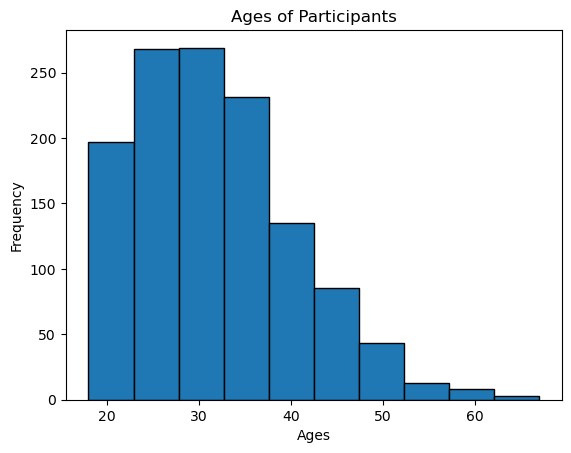

In [13]:
# Creating Histogram of Ages of Respondents
create_histograms(body_measures_df,'age','Ages',bins=[15,20,25,30,35,40,45,50,55,60,65,70],outlier=False)

The Histogram of hgt is (array([ 36, 122, 235, 331, 263, 173,  75,  15,   1,   1], dtype=int64), array([147.2 , 153.58, 159.96, 166.34, 172.72, 179.1 , 185.48, 191.86,
       198.24, 204.62, 211.  ]))


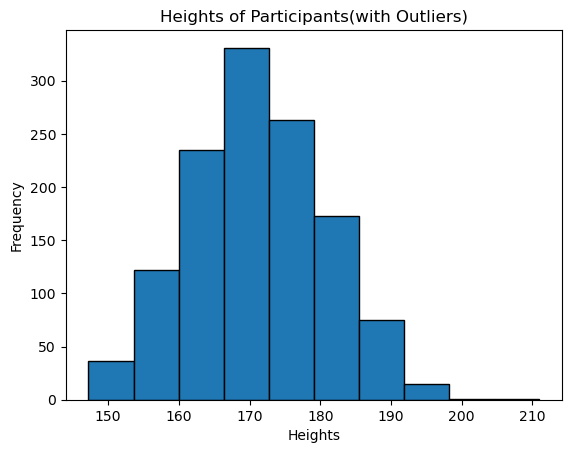

In [14]:
# Creating Histogram of heights of Respondents( With outliers)
create_histograms(body_measures_df,'hgt','Heights')

##### ***Approach for Handling Outliers:*** The Outliers are removed based on the Domain knowledge. For example the values of height less than 147cm is considered Dwarfism and is not normal hence those values are filtered. If someone weighs less than 40, it may indicate some serious helath issues and such respondents are not considered in this study. 
##### The Outliers are further cleansed using the function remove_outliers which removes any values lesser than Lower whiskers and greater than upper whisker in a box plot

The Inter Quartile range of hgt is 13.700000000000017
The Lower Whisker of hgt is 143.54999999999995, The Upper Whisker of hgt is 198.35000000000002 
Below is the summary after removing Outliers from hgt: count    1250.000000
mean      171.156720
std         9.547952
min       147.200000
25%       164.100000
50%       171.000000
75%       177.800000
max       198.100000
Name: hgt, dtype: float64


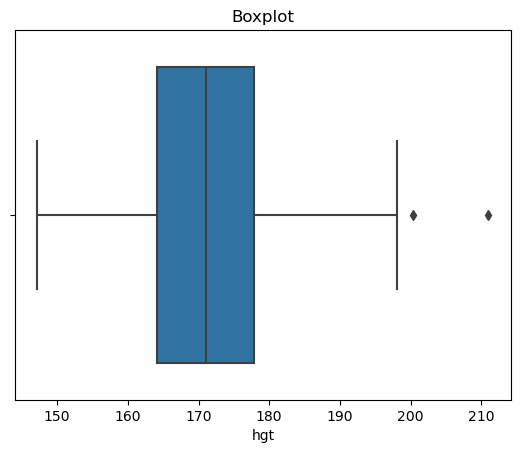

In [15]:
# Removing the outliers 
body_measures_df=remove_outliers(body_measures_df,'hgt')
# Anything below 147 cm is considered dwarfism
body_measures_df=body_measures_df[body_measures_df.hgt>=147]
# Anything above 205 cm is considered too tall
body_measures_df=body_measures_df[body_measures_df.hgt<=205]


The Histogram of hgt is (array([ 25,  58, 158, 212, 254, 215, 168, 106,  45,   9], dtype=int64), array([147.2 , 152.29, 157.38, 162.47, 167.56, 172.65, 177.74, 182.83,
       187.92, 193.01, 198.1 ]))


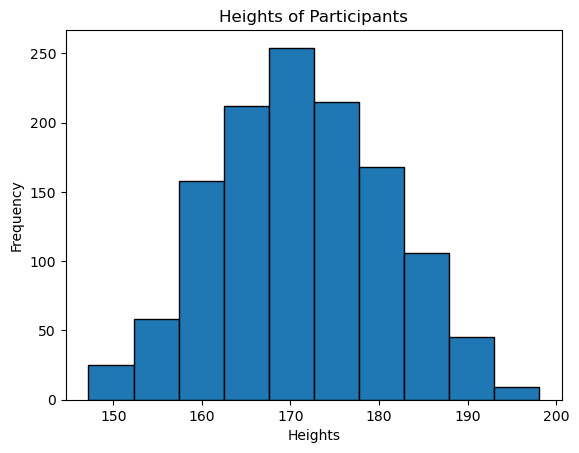

In [16]:
# Creating Histogram of heights of Respondents( After Treating outliers)
create_histograms(body_measures_df,'hgt','Heights',outlier=False)

The Histogram of wgt is (array([  2,   5,  59, 195, 321, 322, 228,  91,  24,   3], dtype=int64), array([ 18.7 ,  28.47,  38.24,  48.01,  57.78,  67.55,  77.32,  87.09,
        96.86, 106.63, 116.4 ]))


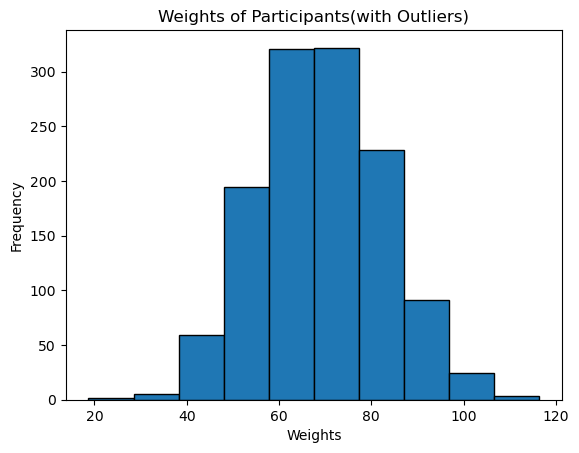

In [17]:
# Creating Histogram of weights of Respondents( with outliers)
create_histograms(body_measures_df,'wgt','Weights')


The Inter Quartile range of wgt is 19.474999999999994
The Lower Whisker of wgt is 29.91250000000001, The Upper Whisker of wgt is 107.81249999999999 
Below is the summary after removing Outliers from wgt: count    1245.000000
mean       69.126908
std        13.254244
min        30.500000
25%        59.200000
50%        68.900000
75%        78.500000
max       106.200000
Name: wgt, dtype: float64


C:\Users\Gurup\AppData\Local\Temp\ipykernel_42656\3201793864.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input_df = input_df[variab < upper_whisker]


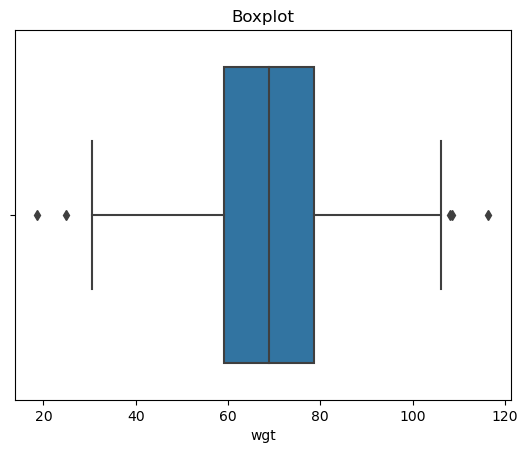

In [18]:
# Removing Outliers
body_measures_df=remove_outliers(body_measures_df,'wgt')
# excluding the weights less than 40 kg
body_measures_df=body_measures_df[body_measures_df.wgt>=40]

The Histogram of wgt is (array([ 37,  77, 204, 216, 229, 184, 154,  86,  32,  14], dtype=int64), array([ 40.  ,  46.62,  53.24,  59.86,  66.48,  73.1 ,  79.72,  86.34,
        92.96,  99.58, 106.2 ]))


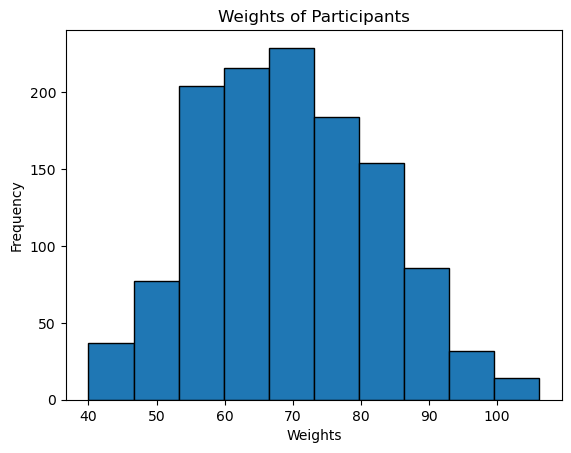

In [19]:
# Creating Histogram of Weights of Respondents( After Treating outliers)
create_histograms(body_measures_df,'wgt','Weights',outlier=False)


The Histogram of sho_gi is (array([  1,   2,   7,  64, 229, 294, 312, 221,  95,   8], dtype=int64), array([ 61.9 ,  69.56,  77.22,  84.88,  92.54, 100.2 , 107.86, 115.52,
       123.18, 130.84, 138.5 ]))


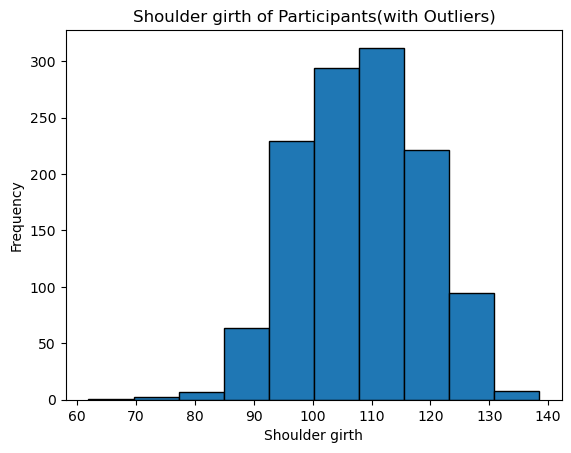

In [20]:
# Creating Histogram of Shoulder Girth of Respondents( With outliers)
create_histograms(body_measures_df,'sho_gi','Shoulder girth')


The Inter Quartile range of sho_gi is 15.799999999999997
The Lower Whisker of sho_gi is 76.6, The Upper Whisker of sho_gi is 139.79999999999998 
Below is the summary after removing Outliers from sho_gi: count    1231.000000
mean      108.389521
std        10.411209
min        76.900000
25%       100.300000
50%       108.300000
75%       116.150000
max       138.500000
Name: sho_gi, dtype: float64


C:\Users\Gurup\AppData\Local\Temp\ipykernel_42656\3201793864.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input_df = input_df[variab < upper_whisker]


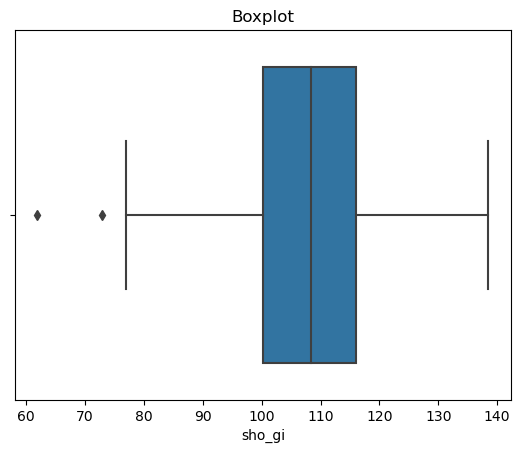

In [21]:
# Removing Outliers
body_measures_df=remove_outliers(body_measures_df,'sho_gi')

The Histogram of sho_gi is (array([  4,  26, 101, 230, 224, 267, 196, 125,  54,   4], dtype=int64), array([ 76.9 ,  83.06,  89.22,  95.38, 101.54, 107.7 , 113.86, 120.02,
       126.18, 132.34, 138.5 ]))


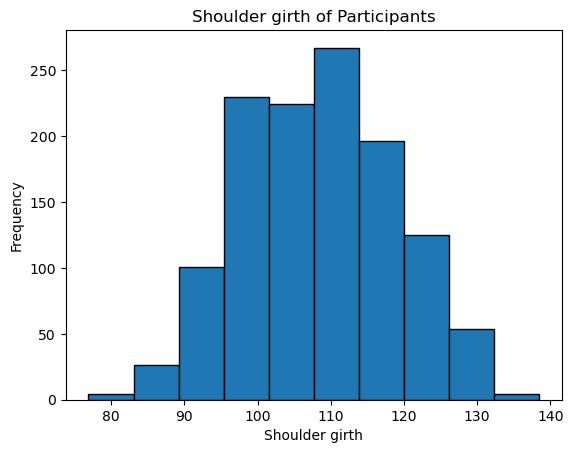

In [22]:
# Creating Histogram of Shoulder Girth of Respondents( After Treating outliers)
create_histograms(body_measures_df,'sho_gi','Shoulder girth',outlier=False)

The Histogram of che_gi is (array([  6,  13,  75, 191, 247, 244, 207, 153,  71,  24], dtype=int64), array([ 62.5 ,  68.15,  73.8 ,  79.45,  85.1 ,  90.75,  96.4 , 102.05,
       107.7 , 113.35, 119.  ]))


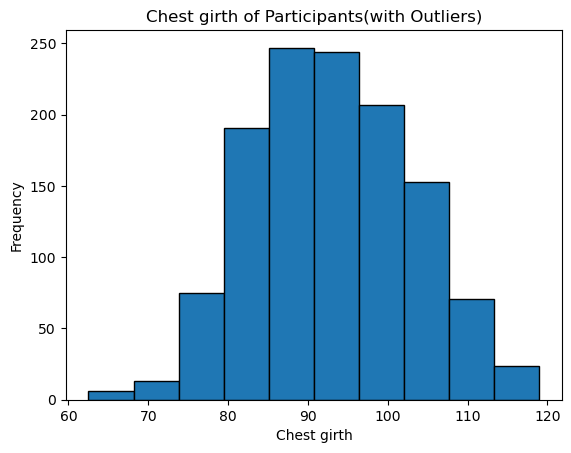

In [23]:
# Creating Histogram of Chest Girth of Respondents( With outliers)
create_histograms(body_measures_df,'che_gi','Chest girth')

The Inter Quartile range of che_gi is 14.799999999999997
The Lower Whisker of che_gi is 63.300000000000004, The Upper Whisker of che_gi is 122.5 
Below is the summary after removing Outliers from che_gi: count    1229.000000
mean       93.105533
std         9.934974
min        63.900000
25%        85.500000
50%        92.800000
75%       100.300000
max       119.000000
Name: che_gi, dtype: float64


C:\Users\Gurup\AppData\Local\Temp\ipykernel_42656\3201793864.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input_df = input_df[variab < upper_whisker]


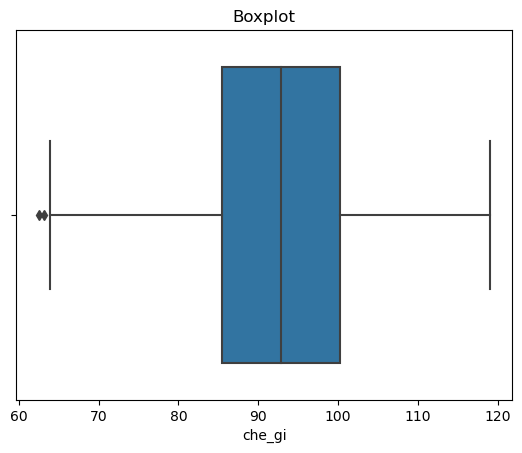

In [24]:
# Treating and Removing outliers
body_measures_df=remove_outliers(body_measures_df,'che_gi')

The Histogram of che_gi is (array([  5,  20,  97, 203, 238, 233, 193, 146,  70,  24], dtype=int64), array([ 63.9 ,  69.41,  74.92,  80.43,  85.94,  91.45,  96.96, 102.47,
       107.98, 113.49, 119.  ]))


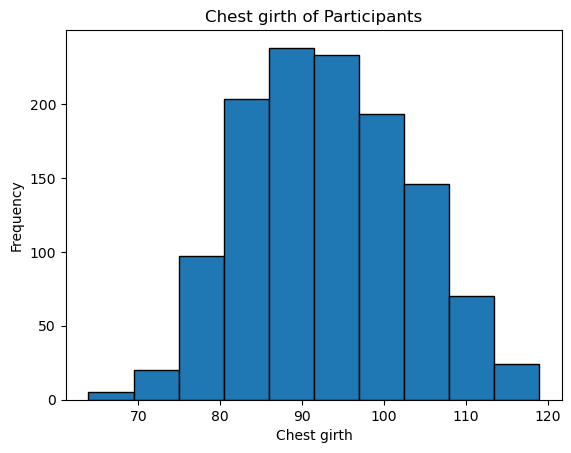

In [25]:
# Creating Histogram of Chest Girth of Respondents( After Treating outliers)
create_histograms(body_measures_df,'che_gi','Chest girth',outlier=False)

The Inter Quartile range of wai_gi is 14.899999999999991
The Lower Whisker of wai_gi is 46.55000000000002, The Upper Whisker of wai_gi is 106.14999999999998 
Below is the summary after removing Outliers from wai_gi: count    1216.000000
mean       76.701480
std        10.524767
min        47.200000
25%        68.900000
50%        76.550000
75%        83.700000
max       105.200000
Name: wai_gi, dtype: float64


C:\Users\Gurup\AppData\Local\Temp\ipykernel_42656\3201793864.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  input_df = input_df[variab < upper_whisker]


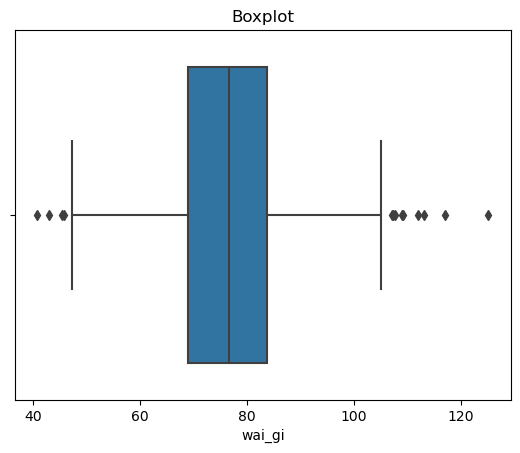

In [26]:
# Creating Histogram of Waist Girth of Respondents( With outliers)
body_measures_df=remove_outliers(body_measures_df,'wai_gi')

The Inter Quartile range of wai_gi is 14.799999999999997
The Lower Whisker of wai_gi is 46.70000000000001, The Upper Whisker of wai_gi is 105.9 
Below is the summary after removing Outliers from wai_gi: count    1216.000000
mean       76.701480
std        10.524767
min        47.200000
25%        68.900000
50%        76.550000
75%        83.700000
max       105.200000
Name: wai_gi, dtype: float64


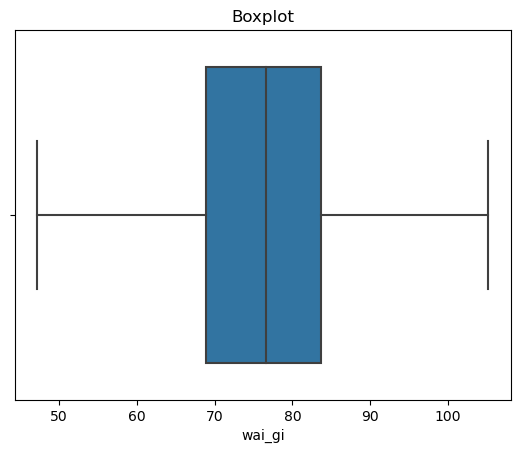

In [27]:
# Removing Outliers
body_measures_df=remove_outliers(body_measures_df,'wai_gi')

The Histogram of wai_gi is (array([ 12,  28, 104, 212, 241, 250, 180, 105,  63,  21], dtype=int64), array([ 47.2,  53. ,  58.8,  64.6,  70.4,  76.2,  82. ,  87.8,  93.6,
        99.4, 105.2]))


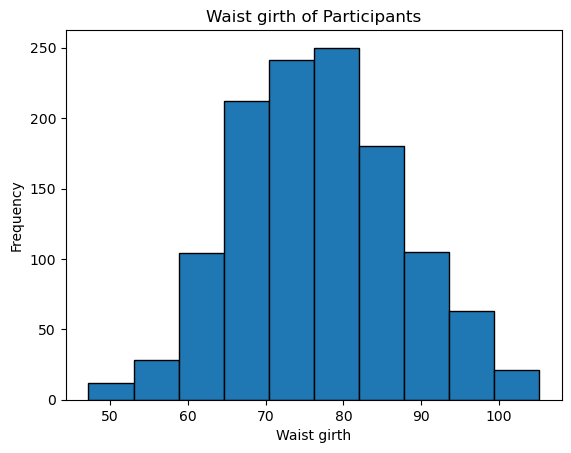

In [28]:
# Creating Histogram of Waist Girth of Respondents( After Treating outliers)
create_histograms(body_measures_df,'wai_gi','Waist girth',outlier=False)

### Question 4

#### Include the other descriptive characteristics about the variables: Mean, Mode, Spread, and Tails (Chapter 2).

In [29]:
def MakeMoreFrames(body_measures_df):
    """
    This function will create more Dataframes that will be used further in this project.
    Returns the new dataframes created.
    """
    # Dataframe that only contains the body measurements of Men
    male_df=body_measures_df[body_measures_df.sex ==1]
    # Dataframe that only contains the body measurements of Women
    female_df=body_measures_df[body_measures_df.sex ==0]
    # Dataframe that only contains the body measurements of Young Men
    young_male_df=male_df[male_df.age_category == 'Young Adult']
    # Dataframe that only contains the body measurements of Young Women
    young_female_df=female_df[female_df.age_category == 'Young Adult']
    # Dataframe that only contains the body measurements of Healthy men and Women
    healthy_df=body_measures_df[body_measures_df.BMI_desc =='Healthy']
    healthy_male_df=healthy_df[healthy_df.sex ==1]
    healthy_female_df=healthy_df[healthy_df.sex ==0]
    return male_df,female_df,young_male_df,young_female_df,healthy_df,healthy_male_df,healthy_female_df       

In [30]:
# Creates various dataframes that will be used further used in this Project
male_df,female_df,young_male_df,young_female_df,healthy_df,healthy_male_df,healthy_female_df=MakeMoreFrames(body_measures_df)
young_male_df.head()

,bia_di,bii_di,bit_di,che_de,che_di,elb_di,wri_di,kne_di,ank_di,sho_gi,...,cal_gi,ank_gi,wri_gi,age,wgt,hgt,sex,BMI,BMI_desc,age_category
6,42.1,28.5,31.7,19.4,28.0,14.0,11.3,19.0,14.4,115.0,...,34.6,20.6,16.0,26,71.8,177.8,1,22.712290,Healthy,Young Adult
7,36.6,26.7,35.1,21.9,30.1,12.2,10.5,18.5,15.6,112.3,...,30.2,20.5,18.1,28,77.7,176.2,1,25.027024,Overweight,Young Adult
21,41.1,27.8,31.4,19.0,31.5,14.5,11.9,18.5,13.0,114.8,...,35.1,21.0,17.0,22,67.2,182.0,1,20.287405,Healthy,Young Adult
29,40.3,27.5,31.4,21.7,28.0,13.3,10.3,18.8,13.2,113.0,...,36.0,21.5,16.6,26,74.6,176.0,1,24.083161,Healthy,Young Adult
36,40.3,23.6,34.4,25.4,30.9,12.0,10.3,19.4,14.0,111.1,...,34.3,20.7,16.0,19,69.7,162.3,1,26.460359,Overweight,Young Adult


In [31]:
def summary_statistics(df,df_name, col_name):
    """
    This function will print the Summary Statistics of the Variable.
    df: Dataframe name in which the Variable resides.
    df_name: Name of the dataframe to be included in single quotes for Display purposes
    col_name: Column name
    """
    print(f"Summary Statistics of {col_name} in {df_name}: ")
    # Prints the Central Tendency such as Mean, Mode and Median
    print(" Central Tendancy :")
    print(f"  Mean is {np.mean(df[col_name])}")
    print(f"  Median is {np.median(df[col_name])}")
    print(f"  Mode is {st.mode(df[col_name])}")
    # Prints the Measures of Variablity such as Variance, Standard Deviation
    print(" Measures of Variablity :")
    print(f"  Variance is {np.var(df[col_name])}")
    print(f"  Standard Deviation is {np.std(df[col_name])}")
    # Prints the measures of spread such as Min, Max, first, Third Quartile
    print(" Measures of Spread :")
    print(f"  The Smallest value is {np.min(df[col_name])}")
    print(f"  The Largest value is {np.max(df[col_name])}")
    quart_25=df[col_name].quantile(0.25)
    print(f"  The First Quartile of {col_name} is {quart_25}")
    quart_75=df[col_name].quantile(0.75)
    print(f"  The Third Quartile of {col_name} is {quart_75}")
    inter_quart=quart_75-quart_25
    print(f"  The Inter Quartile range of {col_name} is {inter_quart}")
    lower_whisker = quart_25-1.5*inter_quart
    upper_whisker = quart_75+1.5*inter_quart
    print(f"  The Lower Whisker of {col_name} is {lower_whisker}, The Upper Whisker of {col_name} is {upper_whisker} ")
    print("\n")
    print("Below is the summary:")
    print(df[col_name].describe())

In [32]:
def CohenEffectSize(group1, group2):
    """Computes Cohen's effect size for two groups. This is done by comparing the difference between the 
    variablity within the groups. 
    
    group1: Series or DataFrame
    group2: Series or DataFrame
    
    returns: float if the arguments are Series;
             Series if the arguments are DataFrames
    """
    # Calculate the difference in mean between the two groups
    diff = group1.mean() - group2.mean()
    # Calculating the variance of the 2 groups
    var1 = group1.var()
    var2 = group2.var()
    # Calculating the size of each group
    size1, size2 = len(group1), len(group2)
    # The Combined variance of 2 groups in measured as follows
    pooled_var = (size1 * var1 + size2 * var2) / (size1 + size2)
    # Calculating Cohens d by diving the difference of mean by the square root of combined variance
    cohens_d = diff / np.sqrt(pooled_var)
    return cohens_d

#### ***Descriptive Characteristics used in the Project:***
##### ***Central Tendancy:*** The measures of central position in a distribution is indicated by the Central Tendancy. We use Mean, median, Mode to describe this.
##### ***Variablity and Measures of Spread:*** This indicates the measure of dispersement in a distribution, for example how distributed the data in a distribution is.  To indicate this we use Variance, Standard Deviation to represent Variablity. To indicate the spread we use minimum, Maximum, First Quartile, Third Quartile, Inter Quartile Range
##### ***Tails:*** If the tail of the distribution is longer on the left side of the distribution, which means the distribution is skewed to the left, the mean is often less than median. If the distribution is skewed to the Right, the mean is often greater than the Median. The mean is usually affected by the outliers in the data.


Summary Statistics of age in male_df: 
 Central Tendancy :
  Mean is 31.708333333333332
  Median is 30.0
  Mode is 29
 Measures of Variablity :
  Variance is 76.53993055555564
  Standard Deviation is 8.74871022240168
 Measures of Spread :
  The Smallest value is 18
  The Largest value is 65
  The First Quartile of age is 25.0
  The Third Quartile of age is 37.0
  The Inter Quartile range of age is 12.0
  The Lower Whisker of age is 7.0, The Upper Whisker of age is 55.0 


Below is the summary:
count    600.000000
mean      31.708333
std        8.756010
min       18.000000
25%       25.000000
50%       30.000000
75%       37.000000
max       65.000000
Name: age, dtype: float64
The Histogram of age is (array([ 87, 129, 134,  90,  69,  55,  17,  10,   3,   6], dtype=int64), array([18. , 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 60.3, 65. ]))


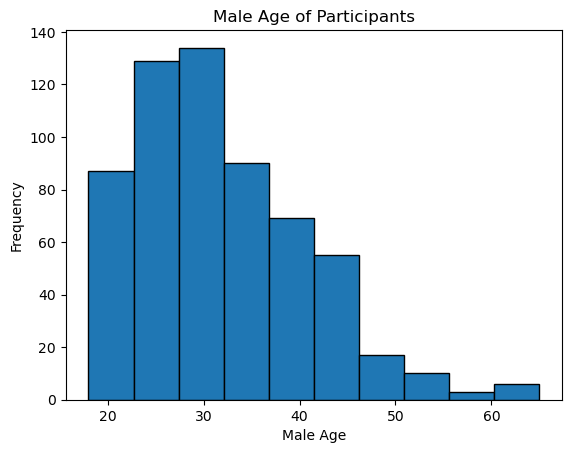

In [33]:
# Summary Statistics of AGE
summary_statistics(male_df,'male_df','age')
create_histograms(male_df,'age','Male Age',outlier=False)

##### ***Interpretation:*** The Summary of age variable in male_df indicates the mean and Median are not too far apart and so it indicates a healthy distribution. Also the mode of 29 indicates many male respondents of age 29. The spread is as expected which is from 18 years till 65 years since we filtered the values below 18 to exclude the Children. The outliers doesn't mean much for age, wo we will ignore that

Summary Statistics of age in female_df: 
 Central Tendancy :
  Mean is 31.196428571428573
  Median is 30.0
  Mode is 25
 Measures of Variablity :
  Variance is 76.21303919294996
  Standard Deviation is 8.730007972101168
 Measures of Spread :
  The Smallest value is 18
  The Largest value is 67
  The First Quartile of age is 24.0
  The Third Quartile of age is 37.0
  The Inter Quartile range of age is 13.0
  The Lower Whisker of age is 4.5, The Upper Whisker of age is 56.5 


Below is the summary:
count    616.000000
mean      31.196429
std        8.737103
min       18.000000
25%       24.000000
50%       30.000000
75%       37.000000
max       67.000000
Name: age, dtype: float64
The Histogram of age is (array([106, 135, 127, 107,  77,  36,  17,   7,   2,   2], dtype=int64), array([18. , 22.9, 27.8, 32.7, 37.6, 42.5, 47.4, 52.3, 57.2, 62.1, 67. ]))
Cohen's d for Male and Female Age is 0.058527233539349244


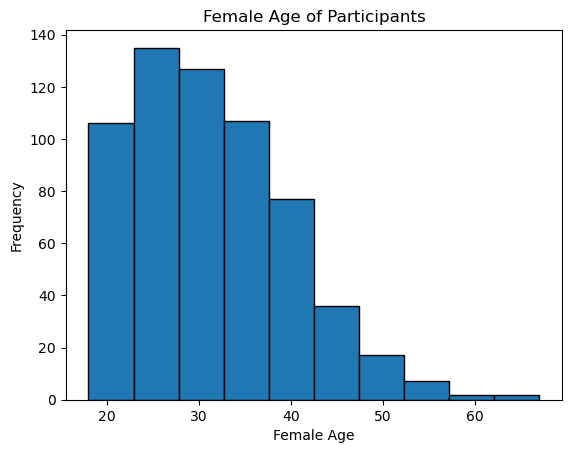

In [34]:
summary_statistics(female_df,'female_df','age')
create_histograms(female_df,'age','Female Age',outlier=False)
cohens_d1= CohenEffectSize(male_df.age, female_df.age)
print(f"Cohen's d for Male and Female Age is {cohens_d1}")

##### ***Interpretation:*** The Summary of age variable in female_df , similar to male_df indicates the mean and Median are not too far apart and so it indicates a healthy distribution. Also the mode of 25 indicates many female respondents of age 25. The spread is as expected which is from 18 years till 67 years since we filtered the values below 18 to exclude the Children.The outliers doesn't mean much for age, wo we will ignore that. The Cohen's d indicates the effect size of 0.059 standard deviations between Male and Female Age.

Summary Statistics of hgt in male_df: 
 Central Tendancy :
  Mean is 173.726
  Median is 174.2
  Mode is 177.8
 Measures of Variablity :
  Variance is 83.10229066666659
  Standard Deviation is 9.116045780198045
 Measures of Spread :
  The Smallest value is 147.6
  The Largest value is 198.1
  The First Quartile of hgt is 167.575
  The Third Quartile of hgt is 180.3
  The Inter Quartile range of hgt is 12.725000000000023
  The Lower Whisker of hgt is 148.48749999999995, The Upper Whisker of hgt is 199.38750000000005 


Below is the summary:
count    600.000000
mean     173.726000
std        9.123652
min      147.600000
25%      167.575000
50%      174.200000
75%      180.300000
max      198.100000
Name: hgt, dtype: float64
The Histogram of hgt is (array([ 12,  15,  45,  90, 112, 140,  91,  61,  30,   4], dtype=int64), array([147.6 , 152.65, 157.7 , 162.75, 167.8 , 172.85, 177.9 , 182.95,
       188.  , 193.05, 198.1 ]))


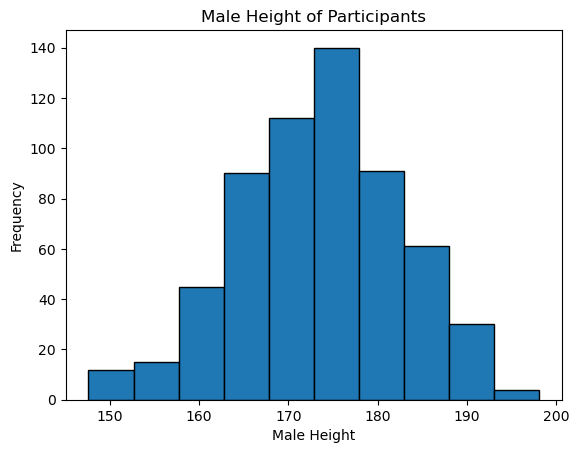

In [35]:
# Summary Statistics of Height
summary_statistics(male_df,'male_df','hgt')
create_histograms(male_df,'hgt','Male Height',outlier=False)

Summary Statistics of hgt in female_df: 
 Central Tendancy :
  Mean is 168.60957792207793
  Median is 167.7
  Mode is 160.0
 Measures of Variablity :
  Variance is 85.2898270945775
  Standard Deviation is 9.235249162560667
 Measures of Spread :
  The Smallest value is 147.2
  The Largest value is 197.9
  The First Quartile of hgt is 161.64999999999998
  The Third Quartile of hgt is 174.725
  The Inter Quartile range of hgt is 13.075000000000017
  The Lower Whisker of hgt is 142.03749999999997, The Upper Whisker of hgt is 194.33750000000003 


Below is the summary:
count    616.000000
mean     168.609578
std        9.242754
min      147.200000
25%      161.650000
50%      167.700000
75%      174.725000
max      197.900000
Name: hgt, dtype: float64
The Histogram of hgt is (array([ 11,  45, 110, 122, 137,  87,  50,  36,  13,   5], dtype=int64), array([147.2 , 152.27, 157.34, 162.41, 167.48, 172.55, 177.62, 182.69,
       187.76, 192.83, 197.9 ]))
Cohen's d for Male and Female Height is -0

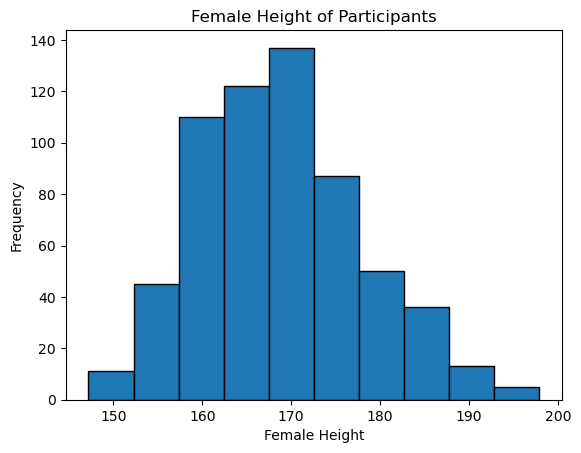

In [36]:
summary_statistics(female_df,'female_df','hgt')
create_histograms(female_df,'hgt','Female Height',outlier=False)
cohens_d2=CohenEffectSize(female_df.hgt, male_df.hgt)
print(f"Cohen's d for Male and Female Height is {cohens_d2}")

##### ***Interpretation:*** The Summary of Height variable in male_df and female_df  indicates the mean and median are much closer. However The mean and Median  height of Men are higher than that of Women indicating Men are overall taller than women, per this dataset. There are more men of height 177.8 cm and more women of 160cm height(Mode). The spread of height is not much as the outliers were removed, so the distribution is close to Normal. In the Male_df, the mean is slightly lesser than Median, indicating a slight skewed to the left  and has  a small left tail. In the female_df, the mean is slightly greater than Median, indicating a small Right tail and is slightly skewed to the right. The result of Cohen's d indicates that Women height is lesser than Men height by 0.558 Standard Deviations. Which indicates Women are shorter than Men , per this dataset.

Summary Statistics of wgt in male_df: 
 Central Tendancy :
  Mean is 72.95983333333332
  Median is 72.7
  Mode is 84.1
 Measures of Variablity :
  Variance is 157.1708033055558
  Standard Deviation is 12.536778027290577
 Measures of Spread :
  The Smallest value is 40.0
  The Largest value is 102.3
  The First Quartile of wgt is 64.5
  The Third Quartile of wgt is 82.7
  The Inter Quartile range of wgt is 18.200000000000003
  The Lower Whisker of wgt is 37.199999999999996, The Upper Whisker of wgt is 110.0 


Below is the summary:
count    600.000000
mean      72.959833
std       12.547238
min       40.000000
25%       64.500000
50%       72.700000
75%       82.700000
max      102.300000
Name: wgt, dtype: float64
The Histogram of wgt is (array([ 12,  23,  51,  70, 100, 117,  92,  86,  35,  14], dtype=int64), array([ 40.  ,  46.23,  52.46,  58.69,  64.92,  71.15,  77.38,  83.61,
        89.84,  96.07, 102.3 ]))


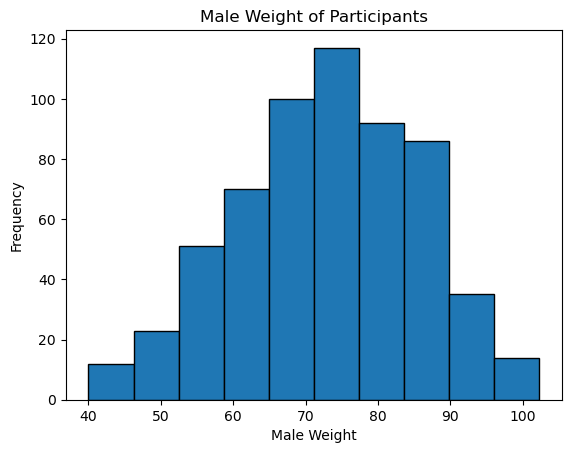

In [37]:
# Summary Statistics of Weight
summary_statistics(male_df,'male_df','wgt')
create_histograms(male_df,'wgt','Male Weight',outlier=False)

Summary Statistics of wgt in female_df: 
 Central Tendancy :
  Mean is 65.87402597402597
  Median is 64.1
  Mode is 63.6
 Measures of Variablity :
  Variance is 148.87864353179305
  Standard Deviation is 12.20158364851846
 Measures of Spread :
  The Smallest value is 40.2
  The Largest value is 106.2
  The First Quartile of wgt is 56.6
  The Third Quartile of wgt is 73.6
  The Inter Quartile range of wgt is 16.999999999999993
  The Lower Whisker of wgt is 31.100000000000012, The Upper Whisker of wgt is 99.09999999999998 


Below is the summary:
count    616.000000
mean      65.874026
std       12.211500
min       40.200000
25%       56.600000
50%       64.100000
75%       73.600000
max      106.200000
Name: wgt, dtype: float64
The Histogram of wgt is (array([ 23,  54, 144, 129, 102,  75,  53,  22,   8,   6], dtype=int64), array([ 40.2,  46.8,  53.4,  60. ,  66.6,  73.2,  79.8,  86.4,  93. ,
        99.6, 106.2]))
Cohen's d for Male and Female Weight is 0.5724379199821983


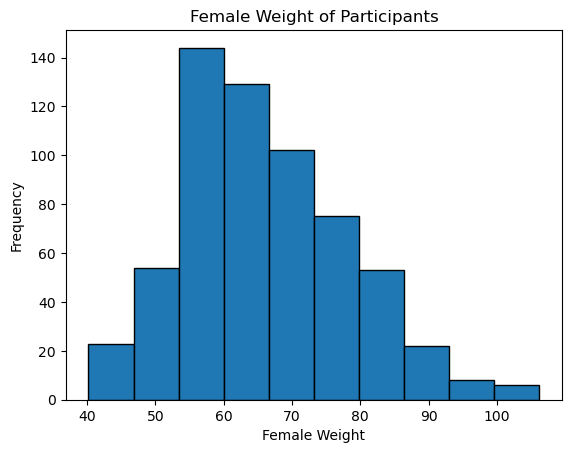

In [38]:
summary_statistics(female_df,'female_df','wgt')
create_histograms(female_df,'wgt','Female Weight',outlier=False)
cohens_d3=CohenEffectSize(male_df.wgt, female_df.wgt)
print(f"Cohen's d for Male and Female Weight is {cohens_d3}")

##### ***Interpretation:*** The Summary of Weight variable in male_df indicates the mean and median are much closer. In the female_df, the mean is slightly higher than Median indicating a Right skew and a tail on the Right. There are more men of weight 84.1kg while more men that weighs 63.6kg. Result of Cohen's d indicates that Men are heavier than women by 0.572 Standard deviations. The spread of weights for both men and women are over a wide range of 40kg to 106kg. So there maybe some outliers outside the range.

Summary Statistics of sho_gi in male_df: 
 Central Tendancy :
  Mean is 111.55716666666667
  Median is 112.45
  Mode is 117.3
 Measures of Variablity :
  Variance is 100.82981530555553
  Standard Deviation is 10.04140504638447
 Measures of Spread :
  The Smallest value is 76.9
  The Largest value is 137.9
  The First Quartile of sho_gi is 104.975
  The Third Quartile of sho_gi is 118.7
  The Inter Quartile range of sho_gi is 13.725000000000009
  The Lower Whisker of sho_gi is 84.38749999999999, The Upper Whisker of sho_gi is 139.28750000000002 


Below is the summary:
count    600.000000
mean     111.557167
std       10.049783
min       76.900000
25%      104.975000
50%      112.450000
75%      118.700000
max      137.900000
Name: sho_gi, dtype: float64
The Histogram of sho_gi is (array([  2,  12,  25,  61,  81, 151, 135,  93,  38,   2], dtype=int64), array([ 76.9,  83. ,  89.1,  95.2, 101.3, 107.4, 113.5, 119.6, 125.7,
       131.8, 137.9]))


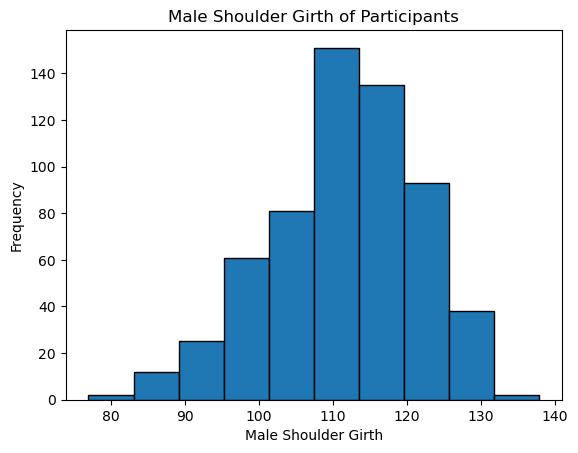

In [39]:
# Summary Statistics of Shoulder Girth
summary_statistics(male_df,'male_df','sho_gi')
create_histograms(male_df,'sho_gi','Male Shoulder Girth',outlier=False)

Summary Statistics of sho_gi in female_df: 
 Central Tendancy :
  Mean is 105.23344155844156
  Median is 104.0
  Mode is 100.8
 Measures of Variablity :
  Variance is 96.4737842595716
  Standard Deviation is 9.822106915502987
 Measures of Spread :
  The Smallest value is 82.0
  The Largest value is 138.5
  The First Quartile of sho_gi is 98.1
  The Third Quartile of sho_gi is 111.4
  The Inter Quartile range of sho_gi is 13.300000000000011
  The Lower Whisker of sho_gi is 78.14999999999998, The Upper Whisker of sho_gi is 131.35000000000002 


Below is the summary:
count    616.000000
mean     105.233442
std        9.830089
min       82.000000
25%       98.100000
50%      104.000000
75%      111.400000
max      138.500000
Name: sho_gi, dtype: float64
The Histogram of sho_gi is (array([ 10,  45, 121, 136, 125,  85,  51,  28,  13,   2], dtype=int64), array([ 82.  ,  87.65,  93.3 ,  98.95, 104.6 , 110.25, 115.9 , 121.55,
       127.2 , 132.85, 138.5 ]))
Cohen's d for Male and Female Should

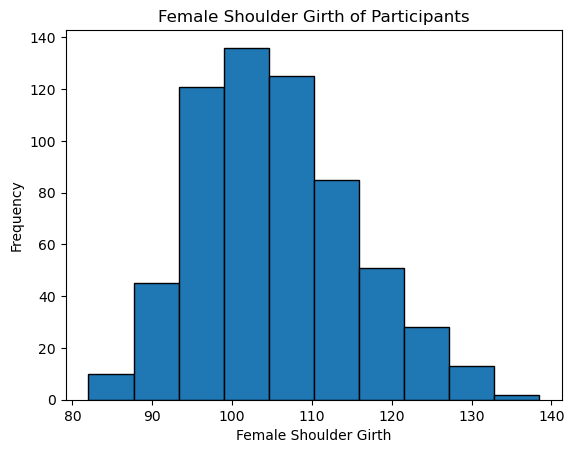

In [40]:
summary_statistics(female_df,'female_df','sho_gi')
create_histograms(female_df,'sho_gi','Female Shoulder Girth',outlier=False)
cohens_d4=CohenEffectSize(male_df.sho_gi, female_df.sho_gi)
print(f"Cohen's d for Male and Female Shoulder Girth is {cohens_d4}")

##### ***Interpretation:*** The Summary of the Shoulder girth variable in male_df and female_df indicates, the mean and median are much closer and not too far apart. In male_df, the mean is less than median indicating left skew/ left tail, while in female_df, the mean is greater than median indicating positive skew/ right tail. The results of Cohen's d indicates, the Men have bigger shoulder than women by 0.636 Standard deviations. The spread of the data is over a wide range of 76 to 138 cm

Summary Statistics of che_gi in body_measures_df: 
 Central Tendancy :
  Mean is 93.07228618421054
  Median is 92.8
  Mode is 88.2
 Measures of Variablity :
  Variance is 97.88009543125638
  Standard Deviation is 9.893436987784193
 Measures of Spread :
  The Smallest value is 63.9
  The Largest value is 119.0
  The First Quartile of che_gi is 85.5
  The Third Quartile of che_gi is 100.3
  The Inter Quartile range of che_gi is 14.799999999999997
  The Lower Whisker of che_gi is 63.300000000000004, The Upper Whisker of che_gi is 122.5 


Below is the summary:
count    1216.000000
mean       93.072286
std         9.897508
min        63.900000
25%        85.500000
50%        92.800000
75%       100.300000
max       119.000000
Name: che_gi, dtype: float64
The Histogram of che_gi is (array([  5,  20,  95, 202, 235, 231, 193, 145,  67,  23], dtype=int64), array([ 63.9 ,  69.41,  74.92,  80.43,  85.94,  91.45,  96.96, 102.47,
       107.98, 113.49, 119.  ]))


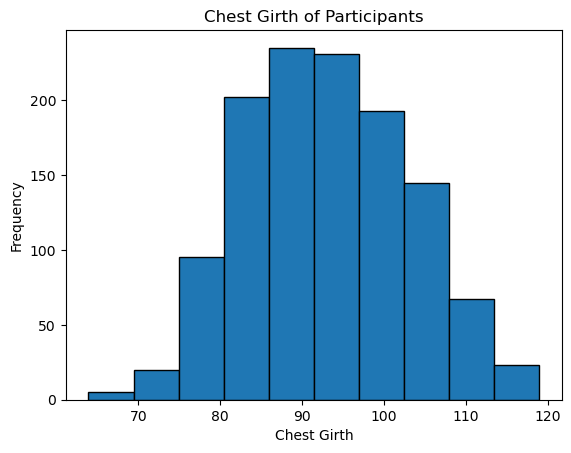

In [41]:
# Summary Statistics of Chest Girth
summary_statistics(body_measures_df,'body_measures_df','che_gi')
create_histograms(body_measures_df,'che_gi','Chest Girth',outlier=False)

##### ***Interpretation:*** The Summary of the Chest girth in the body_measures_df(which includes both mean and women) indicates that mean and Median values are closer. Mean greater than Median may indicate a positive skew and right tail. The spread is over a wide range of 63.9 to 119 cm.

Summary Statistics of wai_gi in body_measures_df: 
 Central Tendancy :
  Mean is 76.70148026315789
  Median is 76.55
  Mode is 77.9
 Measures of Variablity :
  Variance is 110.6796195193474
  Standard Deviation is 10.520438180957454
 Measures of Spread :
  The Smallest value is 47.2
  The Largest value is 105.2
  The First Quartile of wai_gi is 68.9
  The Third Quartile of wai_gi is 83.7
  The Inter Quartile range of wai_gi is 14.799999999999997
  The Lower Whisker of wai_gi is 46.70000000000001, The Upper Whisker of wai_gi is 105.9 


Below is the summary:
count    1216.000000
mean       76.701480
std        10.524767
min        47.200000
25%        68.900000
50%        76.550000
75%        83.700000
max       105.200000
Name: wai_gi, dtype: float64
The Histogram of wai_gi is (array([ 12,  28, 104, 212, 241, 250, 180, 105,  63,  21], dtype=int64), array([ 47.2,  53. ,  58.8,  64.6,  70.4,  76.2,  82. ,  87.8,  93.6,
        99.4, 105.2]))


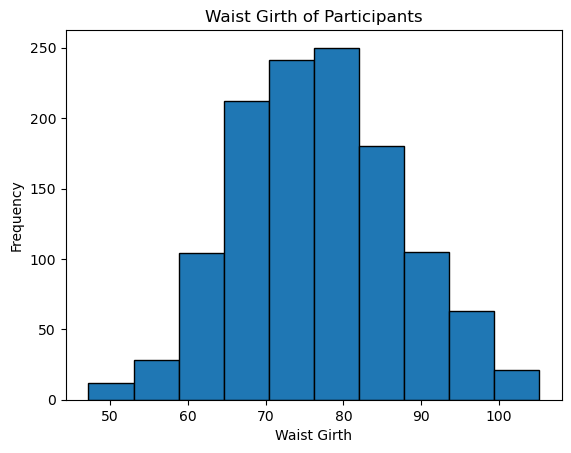

In [42]:
# Summary Statistics of Waist Girth
summary_statistics(body_measures_df,'body_measures_df','wai_gi')
create_histograms(body_measures_df,'wai_gi','Waist Girth',outlier=False)

##### ***Interpretation:*** The Summary of the Waist girth in the body_measures_df(which includes both mean and women) indicates that mean and Median values are very close.  The spread is over a wide range of 47 to 105 cm. There may be a few outliers in the data.

### Question 5

#### Using pg. 29 of your text as an example, compare two scenarios in your data using a PMF. Reminder, this isn’t comparing two variables against each other – it is the same variable, but a different scenario. Almost like a filter. The example in the book is first babies compared to all other babies, it is still the same variable, but breaking the data out based on criteria we are exploring (Chapter 3).

##### ***Approach:***  The PMF and Histogram of the variables such as age, BMI, shoulder girth are compared across different categories such as Young Men- women, Adult Men-Women etc.. In each comparison , the same variable will be compared based on the filter applied on the sex and/or Age Category. The Probability Mass Function lets us compare two distributions without worrying too much about sample size.
##### ***Note:*** All the dataframes that are used in this comparison such as male_df, female_df, young and adult df, all are derived from one parent Dataframe - body_measures_df by using filters.

In [43]:
def create_pmf(df1,df2,var,label1,label2,round_flag=False):
    """
    This function will create Probability Mass function of the variables compared between 2 dataframes.
    df1,df2: The two dataframes in which data will be compared.
    var: The variable used in comparing two scenarios.
    round_flag: Flag that will enable the values to be rounded while computing pmf.
    """
    # If the flag is set to true, values will be rounded, else they wont be
    if round_flag:
        pmf1 = thinkstats2.Pmf(round(df1[var]), label=label1)
        pmf2 = thinkstats2.Pmf(round(df2[var]), label=label2)
    else:
        pmf1 = thinkstats2.Pmf(df1[var], label=label1)
        pmf2 = thinkstats2.Pmf(df2[var], label=label2)
    return pmf1,pmf2

In [44]:
def plot_Hist(pmf1,pmf2,axis=None,xlabel=None,ylabel=None,title=None):
    """
    This function will plot the histogram for the 2 pmfs calculated.
    pmf1,pmf2 : The pmf that will be plotted in the Histogram
    axis, xlabel,ylabel,title: Attributes used while plotting.
    """
    thinkplot.PrePlot(2,cols=2)
    # Setting the width to 0.45 so we can see the distance between the bars
    width = 0.45
    # Plotting Histograms
    thinkplot.Hist(pmf1, align='right', width=width)
    thinkplot.Hist(pmf2, align='left', width=width)
    thinkplot.Config(xlabel=xlabel,
                     ylabel=ylabel,
                 title=title,
                  align='right',
                 axis=axis
                     )

In [45]:
def plot_pmf(pmf1,pmf2,axis=None,xlabel=None,ylabel=None,title=None):
    """
    This function will plot the PMF for the 2 pmfs calculated.
    pmf1,pmf2 : The pmf that will be plotted in the Histogram
    axis, xlabel,ylabel,title: Attributes used while plotting.
    """
    thinkplot.PrePlot(2)
    thinkplot.SubPlot(2)
    # Plotting the PMF here
    thinkplot.Pmfs([pmf1, pmf2])   
    thinkplot.Config(xlabel=xlabel,
                     ylabel=ylabel,
                 title=title,
                  align="right",
                 axis=axis
                     )

In [46]:
# Comparing the Young Men-Women Ages using the variable 'age' :
# Creating dataframes by applying filters 
young_male_df=male_df[male_df.age_category == 'Young Adult']
young_female_df=female_df[female_df.age_category == 'Young Adult']
# Creating pmf using create_pmf function
ym_age_pmf,yf_age_pmf=create_pmf(young_male_df,young_female_df,'age','YoungMale_ages','YoungFemale_ages')

In [47]:
# Printing the values of PMF
ym_age_pmf

Pmf({29: 0.12996389891696752, 25: 0.10108303249097474, 23: 0.10108303249097474, 22: 0.09747292418772563, 24: 0.09386281588447654, 28: 0.09025270758122744, 27: 0.09025270758122744, 21: 0.08664259927797835, 26: 0.07942238267148015, 20: 0.06859205776173286, 19: 0.043321299638989175, 18: 0.018050541516245487}, 'YoungMale_ages')

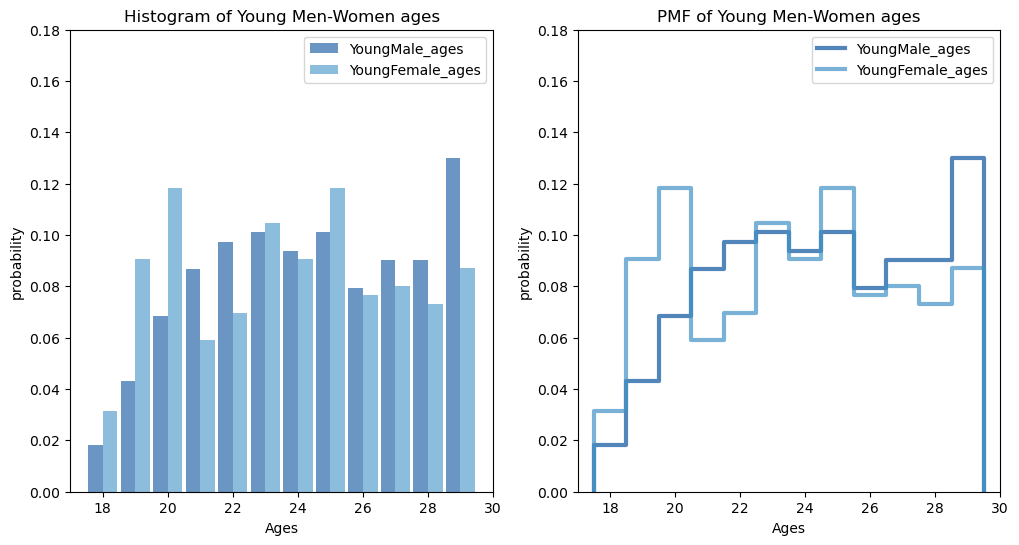

In [48]:
# Plotting the results of Histogram and PMF of Young Men and Women Ages
plot_Hist(ym_age_pmf,yf_age_pmf,axis=[17, 30, 0, 0.18], xlabel='Ages',ylabel='probability',title='Histogram of Young Men-Women ages')
plot_pmf(ym_age_pmf,yf_age_pmf,axis=[17, 30, 0, 0.18], xlabel='Ages',ylabel='probability',title='PMF of Young Men-Women ages')

##### ***Interpretation:*** The Results of the histogram of Young men and women indicates that there are many young women around age 20 and 25 in the study. There are more young Men of age 29 in the study. As the bars are close to each other in histogram,  the results can be studied easily from the PMF plot

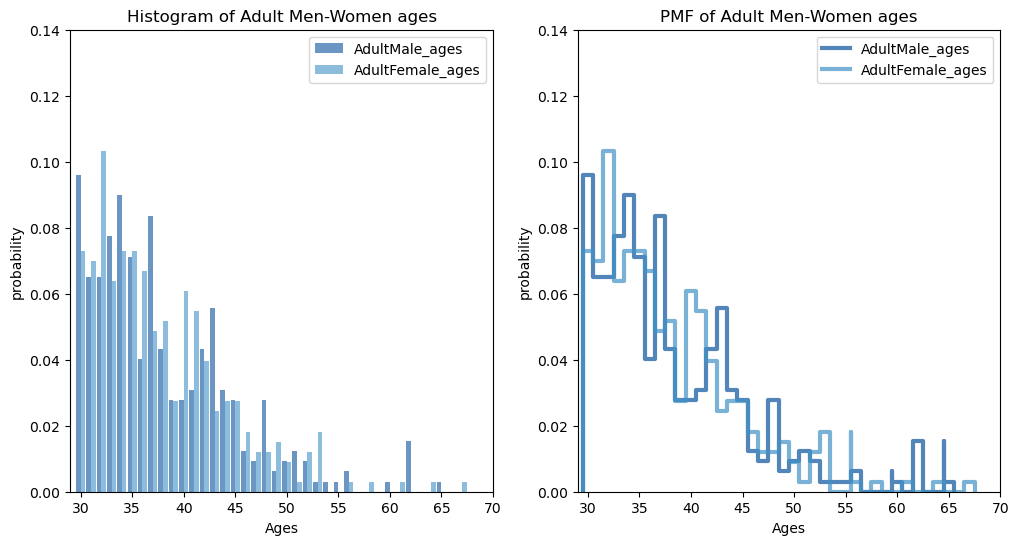

In [49]:
# Plotting the results of Histogram and PMF of Adult Men and Women Ages
adult_male_df=male_df[male_df.age_category == 'Adult']
adult_female_df=female_df[female_df.age_category == 'Adult']
am_age_pmf,af_age_pmf=create_pmf(adult_male_df,adult_female_df,'age','AdultMale_ages','AdultFemale_ages')
plot_Hist(am_age_pmf,af_age_pmf,axis=[29, 70, 0, 0.14], xlabel='Ages',ylabel='probability',title='Histogram of Adult Men-Women ages')
plot_pmf(am_age_pmf,af_age_pmf,axis=[29, 70, 0, 0.14], xlabel='Ages',ylabel='probability',title='PMF of Adult Men-Women ages')


##### ***Interpretation:*** The results of Histogram and PMF of Adult men and women(age range is from 30 to 68) indicates that there are more people in the dataset of age range 30-50 than 50+. There are more women of age 33-34 than men.There are more men of age 37 than women.

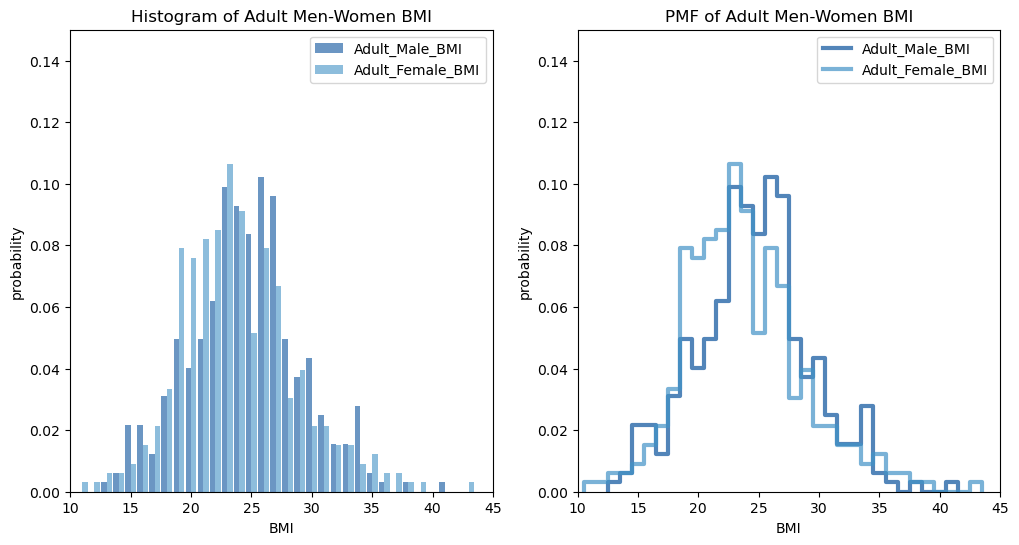

In [50]:
# Plotting the results of Histogram and PMF of Adult Men and Women BMI
am_bmi_pmf,af_bmi_pmf=create_pmf(adult_male_df,adult_female_df,'BMI','Adult_Male_BMI','Adult_Female_BMI',round_flag=True)
plot_Hist(am_bmi_pmf,af_bmi_pmf,axis=[10, 45, 0, 0.15], xlabel='BMI',ylabel='probability',title='Histogram of Adult Men-Women BMI')
plot_pmf(am_bmi_pmf,af_bmi_pmf,axis=[10, 45, 0, 0.15], xlabel='BMI',ylabel='probability',title='PMF of Adult Men-Women BMI')


##### ***Interpretation:*** The results of Histogram of BMI of Adult men and women indicates that there are more healthy women(BMI of 22-23) than Men. Also more adult men are overweight (BMI between 25-30) compared to adult women. There are some really Obese women (BMI =43) which is more than any Obese adult men in the study. Also there are more underweight adult men (BMI <18.5) compared to adult women.

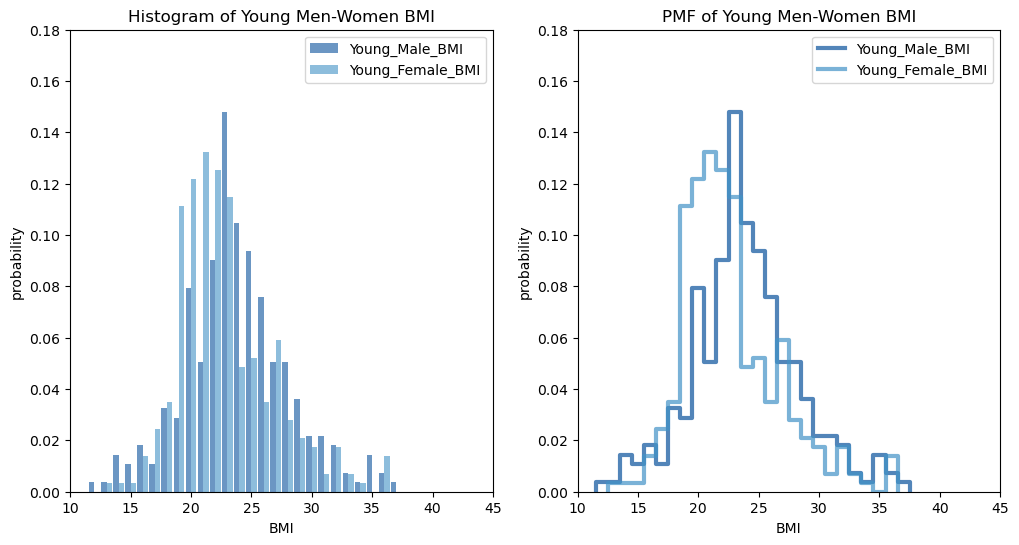

In [51]:
# Plotting the results of Histogram and PMF of Young Men and Women BMI
ym_bmi_pmf,yf_bmi_pmf=create_pmf(young_male_df,young_female_df,'BMI','Young_Male_BMI','Young_Female_BMI',round_flag=True)
plot_Hist(ym_bmi_pmf,yf_bmi_pmf,axis=[10, 45, 0, 0.18], xlabel='BMI',ylabel='probability',title='Histogram of Young Men-Women BMI')
plot_pmf(ym_bmi_pmf,yf_bmi_pmf,axis=[10, 45, 0, 0.18], xlabel='BMI',ylabel='probability',title='PMF of Young Men-Women BMI')


##### ***Interpretation:*** The results of Histogram of BMI of Young men and women indicates that  there are good number of Healthy young men and women. Most healthy young men are of BMI 22-23 and most healthy young women are between BMI 19-22 range. There are more underweight young men compared to Women. Also there are some Overweight and Obese Young men and Women. In the Overweight category, there are more young men than women.

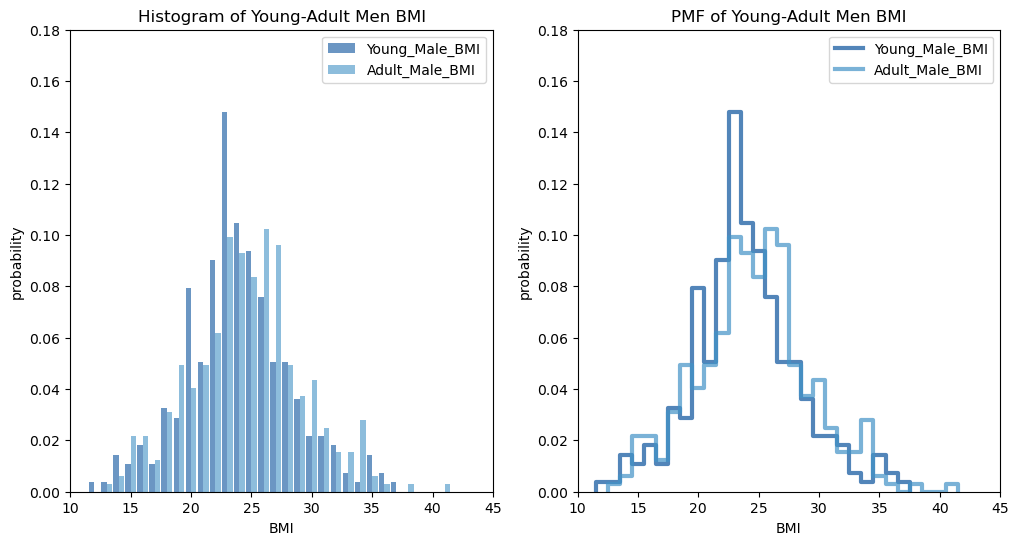

In [52]:
# Plotting the results of Histogram and PMF of Young and Adult Men BMI
plot_Hist(ym_bmi_pmf,am_bmi_pmf,axis=[10, 45, 0, 0.18], xlabel='BMI',ylabel='probability',title='Histogram of Young-Adult Men BMI')
plot_pmf(ym_bmi_pmf,am_bmi_pmf,axis=[10, 45, 0, 0.18], xlabel='BMI',ylabel='probability',title='PMF of Young-Adult Men BMI')


##### ***Interpretation:*** The results of Histogram of BMI of Young vs Adult  men indicates that there are more healthy Young men compared to healthy Adult men. There are more Overweight & Obese adult men compared to Young men. There are some really Obese adult men, not too obese in the young men category. Surprisingly, there are more underweight adult men than underweight young men.

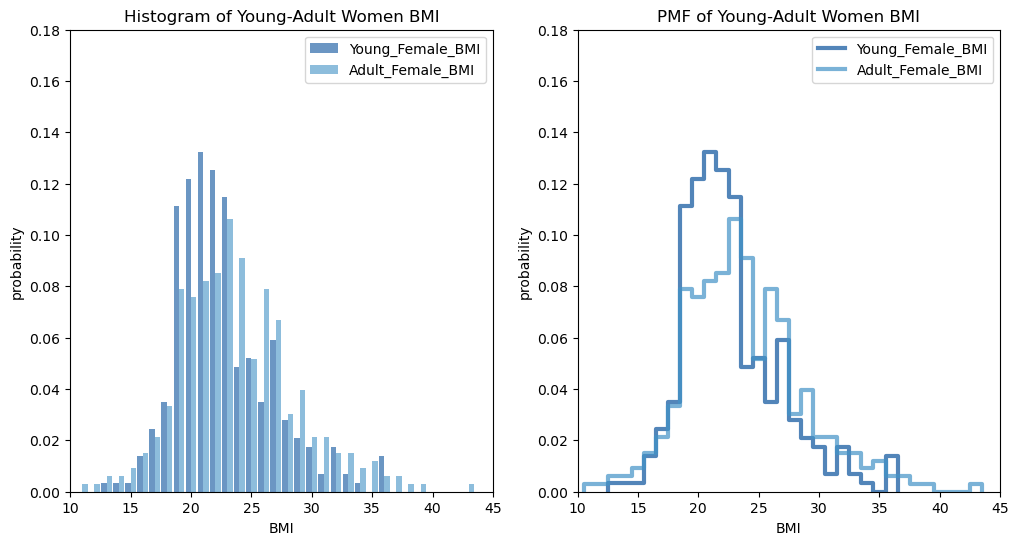

In [53]:
# Plotting the results of Histogram and PMF of Young and Adult Women BMI
plot_Hist(yf_bmi_pmf,af_bmi_pmf,axis=[10, 45, 0, 0.18], xlabel='BMI',ylabel='probability',title='Histogram of Young-Adult Women BMI')
plot_pmf(yf_bmi_pmf,af_bmi_pmf,axis=[10, 45, 0, 0.18], xlabel='BMI',ylabel='probability',title='PMF of Young-Adult Women BMI')


##### ***Interpretation:*** The results of Histogram of BMI of Young vs Adult  women indicates Young women are much healthier than Adult women. There are some overweight young women, but its mostly Adult women. There are some really obese adult women, not so many in the young women category. Also there are many underweight adult women. Overall, Young women are mostly  healthy,  per the dataset.

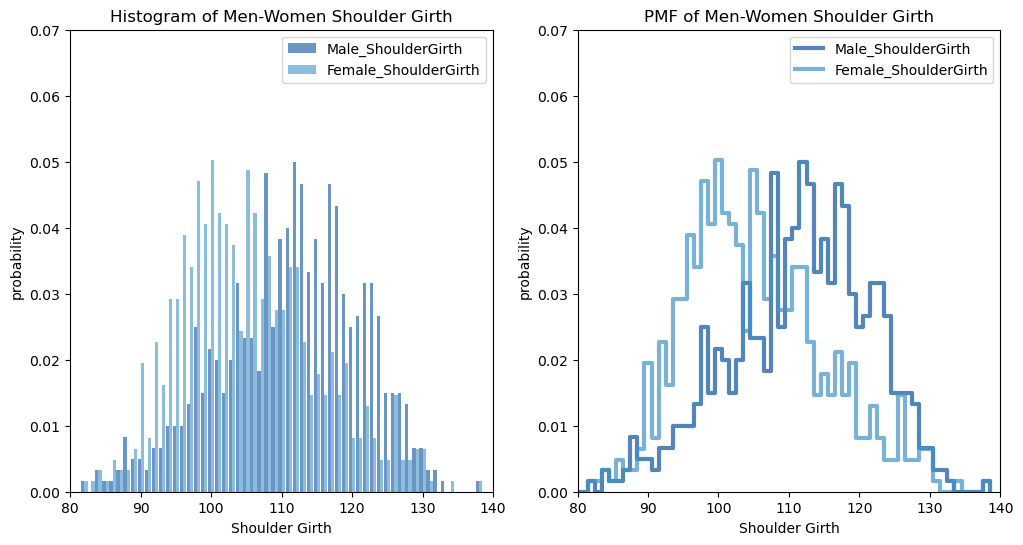

In [54]:
# Plotting the results of Histogram and PMF of Male and Female Shoulder girth
male_sho_pmf,female_sho_pmf=create_pmf(male_df,female_df,'sho_gi','Male_ShoulderGirth','Female_ShoulderGirth',round_flag=True)
plot_Hist(male_sho_pmf,female_sho_pmf,axis=[80, 140, 0, 0.07], xlabel='Shoulder Girth',ylabel='probability',title='Histogram of Men-Women Shoulder Girth')
plot_pmf(male_sho_pmf,female_sho_pmf,axis=[80, 140, 0, 0.07], xlabel='Shoulder Girth',ylabel='probability',title='PMF of Men-Women Shoulder Girth')

#####  ***Interpretation:*** The Results of PMF of shoulder girth indicates that there are more men with broader shoulders(range of 107-130cm) than compared to women. There are more women with shoulder girth of 90-105cm compared to men. Overall, this indicates Men have broader shoulders compared to women, in our dataset

### Question 6

#### Create 1 CDF with one of your variables, using page 41-44 as your guide, what does this tell you about your variable and how does it address the question you are trying to answer (Chapter 4).

#### ***Approach:*** To approach some of the questions that we  are trying to solve in this study, we plot the Cumulative Distribution function between the same variable from 2 dataframes and see the difference. We will also calculate the percentile values from the plot to confirm the results from PMF section.

In [55]:
def create_cdf(df1,df2,var,label1,label2):
    """
    This function creates CDF for the variable from the 2 dataframes that we are trying to compare.
    df1,df2: The 2 dataframes that contains the variable we are trying to compare
    var: The variable for which CDF is created.
    label1,label2: Labels used to distinguish the variable from dataframes
    """
    cdf1 = thinkstats2.Cdf(df1[var], label=label1)
    cdf2 = thinkstats2.Cdf(df2[var], label=label2)
    return cdf1, cdf2      

In [56]:
def plot_cdf(cdf1,cdf2,xlabel,title):
    """
    This function plots the CDF.
    cdf1,cdf2: The CDFs that we are trying to plot and compare
    xlabel, title: Attributes used in the Plot
    """
    thinkplot.PrePlot(2)
    thinkplot.Cdfs([cdf1, cdf2])
    thinkplot.Config(xlabel=xlabel, ylabel='CDF',title=title)
    

30 30


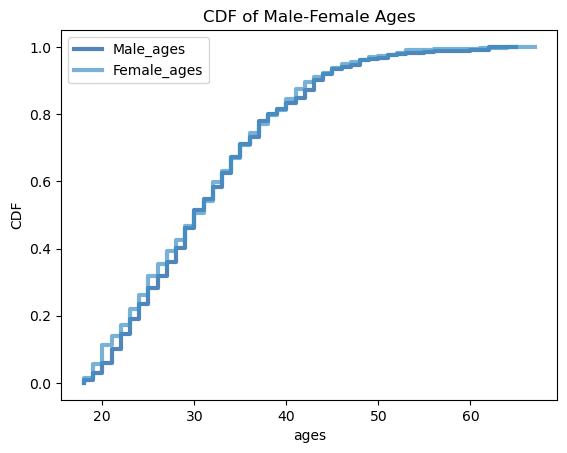

In [57]:
# Comparing the CDF of men and Women ages
male_age_cdf,female_age_cdf=create_cdf(male_df,female_df,'age',label1='Male_ages',label2='Female_ages')
print(male_age_cdf.Percentile(50),female_age_cdf.Percentile(50))
plot_cdf(male_age_cdf,female_age_cdf,xlabel='ages',title='CDF of Male-Female Ages')

##### ***Interpretation:*** The CDF plot of Men- Women ages indicates the distribution is pretty similar, however there may be slightly fewer young women than men. The gap becoms short at they age.

24.013840830449826 22.590064173327928


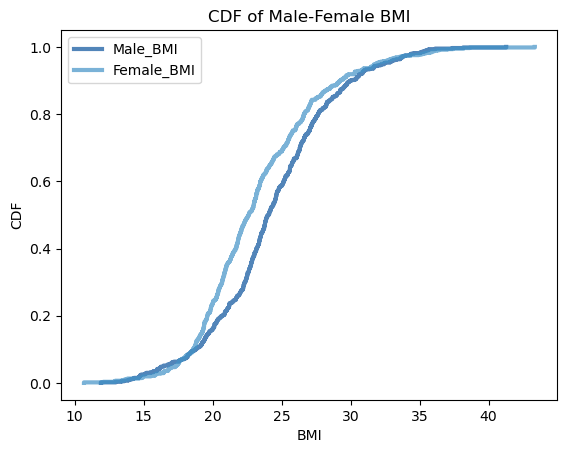

In [58]:
# Comparing the CDF of Men and Women BMI
male_bmi_cdf,female_bmi_cdf=create_cdf(male_df,female_df,'BMI',label1='Male_BMI',label2='Female_BMI')
print(male_bmi_cdf.Percentile(50),female_bmi_cdf.Percentile(50))
plot_cdf(male_bmi_cdf,female_bmi_cdf,xlabel='BMI',title='CDF of Male-Female BMI')

##### ***Interpretation:*** The CDF plot of Men-Women BMI indicates that Men in general have higher BMI compared to women in the BMI range of 18-30. The results of Median(Percentile(50) confirms this. The Gap get smaller in the higher BMI range. There are fewer underweight men compared to underweight women.

23.52191149940716 24.53732484526626


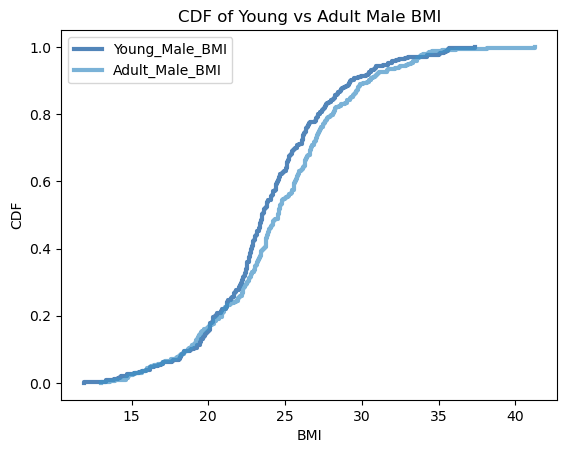

In [59]:
# Comparing the CDF of Adult vs Young Men BMI
ym_bmi_cdf,am_bmi_cdf=create_cdf(young_male_df,adult_male_df,'BMI',label1='Young_Male_BMI',label2='Adult_Male_BMI')
print(ym_bmi_cdf.Percentile(50),am_bmi_cdf.Percentile(50))
plot_cdf(ym_bmi_cdf,am_bmi_cdf,xlabel='BMI',title='CDF of Young vs Adult Male BMI')

##### ***Interpretation:*** The CDF plot of Young vs Adult men indicates that, Young men are over all healthier compared to adult men, the BMI values are lesser than adult men overall. This can be confirmed from the Median - Percentile(50) results. There are almost same number of underweight adult and young men.

21.955230661100995 23.241373400835048


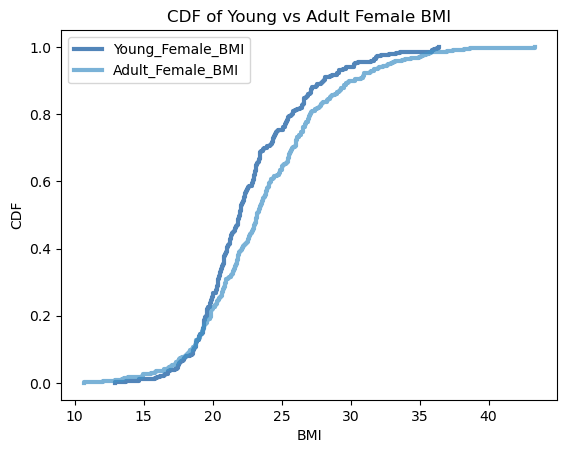

In [60]:
# Comparing the CDF of Adult vs Young Women BMI
yf_bmi_cdf,af_bmi_cdf=create_cdf(young_female_df,adult_female_df,'BMI',label1='Young_Female_BMI',label2='Adult_Female_BMI')
print(yf_bmi_cdf.Percentile(50),af_bmi_cdf.Percentile(50))
plot_cdf(yf_bmi_cdf,af_bmi_cdf,xlabel='BMI',title='CDF of Young vs Adult Female BMI')

##### ***Interpretation:*** The CDF plot of Young vs Adult Women indicates that, Young Women are over all healthier compared to adult Women, the BMI values are lesser than adult Women overall. This can be confirmed from the Median - Percentile(50) results.  

23.52191149940716 21.955230661100995


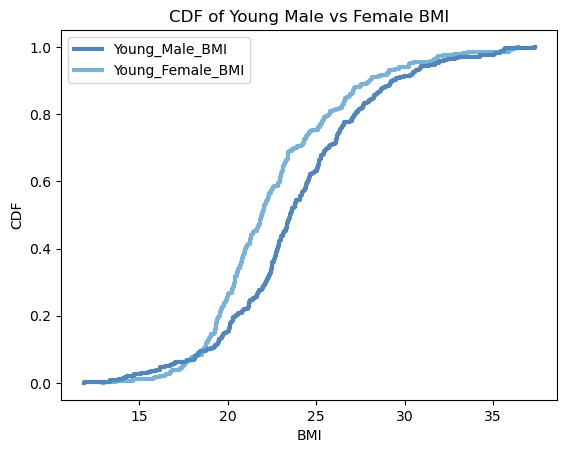

In [61]:
# Comparing the CDF of Young Men vs Women BMI
plot_cdf(ym_bmi_cdf,yf_bmi_cdf,xlabel='BMI',title='CDF of Young Male vs Female BMI')
print(ym_bmi_cdf.Percentile(50),yf_bmi_cdf.Percentile(50))

(24.53732484526626, 23.241373400835048)

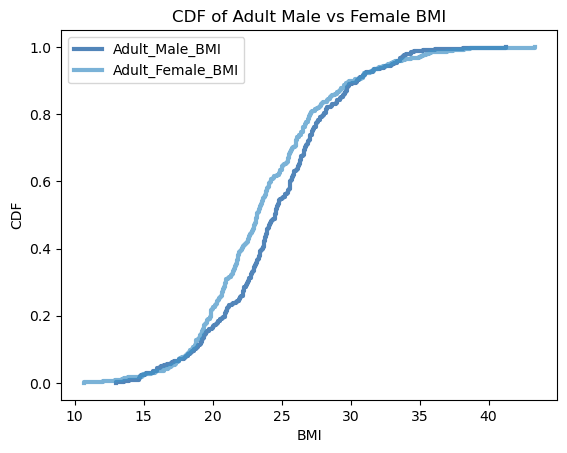

In [62]:
# Comparing the CDF of Adult Men vs Women BMI
plot_cdf(am_bmi_cdf,af_bmi_cdf,xlabel='BMI',title='CDF of Adult Male vs Female BMI')
am_bmi_cdf.Percentile(50),af_bmi_cdf.Percentile(50)

In [63]:
def compare_BMI_cdf(df,label):
    """
    This function prints the Breakdown of percentage of BMI in the given dataframe
    label: The printable name of the dataframe
    """
    print(f"The BMI breakdown of {label} :")
    print(f" Percentage of Underweight population: {df.PercentileRank(18.5)}")
    print(f" Percentage of Healthy population: {df.PercentileRank(25)-df.PercentileRank(18.5)}")
    print(f" Percentage of Overweight population: {df.PercentileRank(30)-df.PercentileRank(25)}")
    print(f" Percentage of Obese population: {100-df.PercentileRank(30)}")
    

In [64]:
compare_BMI_cdf(ym_bmi_cdf,"Young Male")
print("\n")
compare_BMI_cdf(yf_bmi_cdf,"Young Female")
print("\n")
compare_BMI_cdf(am_bmi_cdf,"Adult Male")
print("\n")
compare_BMI_cdf(af_bmi_cdf,"Adult Female")

The BMI breakdown of Young Male :
 Percentage of Underweight population: 9.386281588447654
 Percentage of Healthy population: 53.79061371841155
 Percentage of Overweight population: 28.15884476534297
 Percentage of Obese population: 8.66425992779783


The BMI breakdown of Young Female :
 Percentage of Underweight population: 8.362369337979095
 Percentage of Healthy population: 66.89895470383276
 Percentage of Overweight population: 18.815331010452965
 Percentage of Obese population: 5.923344947735188


The BMI breakdown of Adult Male :
 Percentage of Underweight population: 9.597523219814242
 Percentage of Healthy population: 45.201238390092875
 Percentage of Overweight population: 34.05572755417957
 Percentage of Obese population: 11.145510835913313


The BMI breakdown of Adult Female :
 Percentage of Underweight population: 9.72644376899696
 Percentage of Healthy population: 53.495440729483285
 Percentage of Overweight population: 26.747720364741646
 Percentage of Obese population: 1

##### ***Interpretation:*** The results of the function indicates the breakdown of the BMI percentage in each dataframe. Overall, the Young Women have the most healthy population followed by Young Men. Adult Women are also quite healthy compared to Adult men. Also, Adult men are more obese than any category followed by Adult women.

174.2 167.7


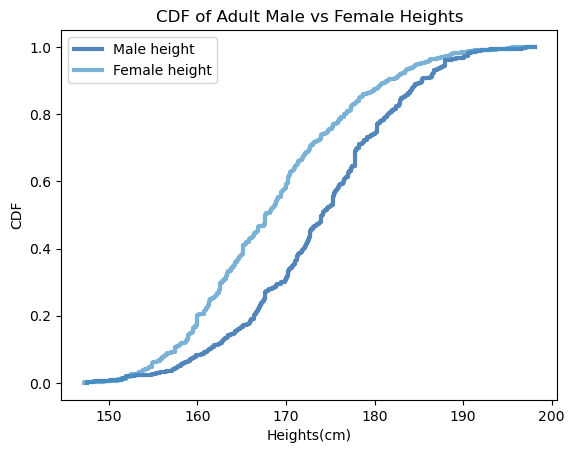

In [65]:
# Comparing the CDF of Adult Men vs Women Height
male_hgt_cdf,female_hgt_cdf=create_cdf(male_df,female_df,'hgt',label1='Male height',label2='Female height')
print(male_hgt_cdf.Percentile(50),female_hgt_cdf.Percentile(50))
plot_cdf(male_hgt_cdf,female_hgt_cdf,xlabel='Heights(cm)',title='CDF of Adult Male vs Female Heights')

#####  ***Interpretation:*** The results of CDF plot on heights indicate that Men are taller for most part compared to women, though there are some really tall men and women and also some short men and women .

112.4 104.0


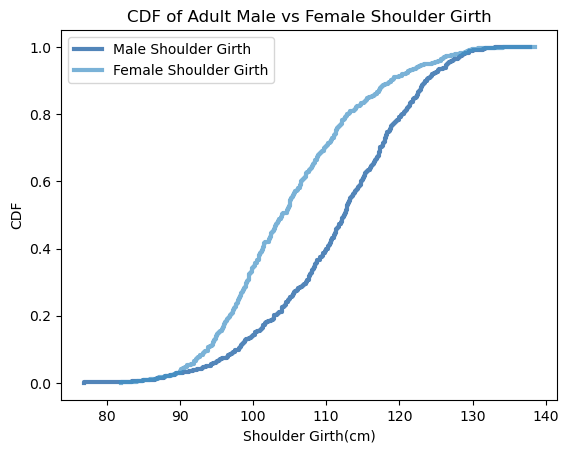

In [66]:
# Comparing the CDF of Adult Men vs Women Shoulder Girth
male_sho_cdf,female_sho_cdf=create_cdf(male_df,female_df,'sho_gi',label1='Male Shoulder Girth',label2='Female Shoulder Girth')
print(male_sho_cdf.Percentile(50),female_sho_cdf.Percentile(50))
plot_cdf(male_sho_cdf,female_sho_cdf,xlabel='Shoulder Girth(cm)',title='CDF of Adult Male vs Female Shoulder Girth')

##### ***Interpretation:*** The results of CDF plot on Shoulder girth indicate that Men have broader shoulders for most part compared to women, though there are some men and women with broader shoulder.

### Question 7

#### Plot 1 analytical distribution and provide your analysis on how it applies to the dataset you have chosen (Chapter 5).

##### ***Approach:***  Normal and LogNormal distribution will be used in this project. The reason Exponential distribution is used for the variables in the dataset because in exponential distribution, the probability of events are likely to occur at any time which may not be true for our sample. The Pareto distribution follows the Pareto principle that 80% of the outcomes are from 20% of the causes, which may not be completely true for our data. Hence we will attempt to see how the Normal and LogNormal distributions fits the model
##### To build the Normal and LogNormal model, we compute the mean and standard variance of the variable we are trying to plot and create a normal Model. we then compare the CDF data with the Model and see how close the data is to the model.  If the Normal distribution does not work as expected we then plot the Lognormal distrubtion by taking the log10 value of the variable. The results can also be deciphered by plotting the Normal probability plot. The closer the data is to the model, the better the Model fits the distribution.

In [67]:
# All function definitions in this section are taken from thinkstats2.py and thinkplot.py which were downloaded earlier
def LeastSquares(xs, ys):
    """Computes a linear least squares fit for ys as a function of xs.
    Args:
        xs: sequence of values
        ys: sequence of values
    Returns:
        tuple of (intercept, slope)
    """
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)
    # Calculating the slope of the line from Covariance
    slope = Cov(xs, ys, meanx, meany) / varx
    # Calculating the Intercept
    inter = meany - slope * meanx
    return inter, slope

In [68]:
def FitLine(xs, inter, slope):
    """Fits a line to the given data.
    xs: sequence of x
    returns: tuple of numpy arrays (sorted xs, fit ys)
    """
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [69]:
def Var(xs, mu=None, ddof=0):
    """Computes variance.
    xs: sequence of values
    mu: option known mean
    ddof: delta degrees of freedom
    returns: float
    """
    xs = np.asarray(xs)
    if mu is None:
        mu = xs.mean()
    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)

In [70]:
def Trim(t, p=0.01):
    """Trims the largest and smallest elements of t.
    Args:
        t: sequence of numbers
        p: fraction of values to trim off each end
    Returns:
        sequence of values
    """
    n = int(p * len(t))
    t = sorted(t)[n:-n]
    return t

In [71]:
def MeanVar(xs, ddof=0):
    """Computes mean and variance.
    Based on http://stackoverflow.com/questions/19391149/
    numpy-mean-and-variance-from-single-function
    xs: sequence of values
    ddof: delta degrees of freedom
    returns: pair of float, mean and var
    """
    xs = np.asarray(xs)
    mean = xs.mean()
    s2 = Var(xs, mean, ddof)
    return mean, s2

In [72]:
def TrimmedMeanVar(t, p=0.01):
    """Computes the trimmed mean and variance of a sequence of numbers.
    Side effect: sorts the list.
    Args:
        t: sequence of numbers
        p: fraction of values to trim off each end
    Returns:
        float
    """
    t = Trim(t, p)
    mu, var = MeanVar(t)
    return mu, var

In [73]:
def RenderNormalCdf(mu, sigma, low, high, n=101):
    """Generates sequences of xs and ps for a Normal CDF.
    mu: parameter
    sigma: parameter
    low: float
    high: float
    n: number of points to render
    returns: numpy arrays (xs, ps)
    """
    xs = np.linspace(low, high, n)
    # Creating a normal distribution
    ps = stats.norm.cdf(xs, mu, sigma)
    return xs, ps

In [74]:
def NormalProbability(ys, jitter=0):
    """Generates data for a normal probability plot.
    ys: sequence of values
    jitter: float magnitude of jitter added to the ys
    returns: numpy arrays xs, ys
    """
    len_ys = len(ys)
    # Creating a normal distribution
    xs = np.random.normal(0, 1, len_ys)
    xs.sort()
    if jitter:
        ys = Jitter(ys, jitter)
    else:
        ys = np.array(ys)
    ys.sort()
    return xs, ys

In [75]:
def CreateNormalModel(input_var):
    """Plots a CDF with a Normal model.
    input_var: input sequence
    """
    # Creating a CDF for the input variable
    cdf = thinkstats2.Cdf(input_var,label='Data')
    print(f"Median of CDF is {cdf.Percentile(50)}")
    # Calculating the Mean ,Variance and Standard Deviation
    mean, var = TrimmedMeanVar(input_var)
    std = np.sqrt(var)
    median=np.median(input_var)
    print("Results from the Model: len(input_variable), mean, std, median ", len(input_var), mean, std, median)
    # Calculating the Min and Max bounds of standard deviation
    xmin = mean - 3 * std
    xmax = mean + 3 * std
    # Plotting the Mormal distribution model
    xs, ps = RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label="model", linewidth=4, color="0.8")
    # Plotting the CDF in the same plot for comparison
    thinkplot.Cdf(cdf)

In [76]:
def CreateNormalPlot(input_var):
    """Generates a normal probability plot of BMIs.
    input_var: BMI sequence
    """
    # Calculating the Mean, Variance and standard deviation of input variable
    mean, var = TrimmedMeanVar(input_var, p=0.01)
    std = np.sqrt(var)
    # setting the X axis limits
    xs = [-4, 4]
    # Plotting the line to compare the model
    xs, ys = FitLine(xs, mean, std)
    thinkplot.Plot(xs, ys, color="0.8", label="model")
    # Plotting the Normal probability plot
    xs, ys = NormalProbability(input_var)
    thinkplot.Plot(xs, ys, label="Data")

Median of CDF is 24.013840830449826
Results from the Model: len(input_variable), mean, std, median  600 24.274128944104028 4.224317303151321 24.039477710128867


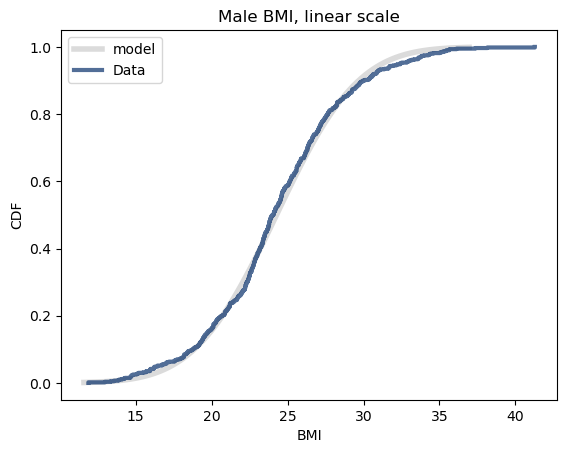

In [77]:
# Calculating the Normal Model of BMI of male_df
male_BMI=male_df.BMI
CreateNormalModel(male_BMI)
thinkplot.Config(
    title="Male BMI, linear scale",
    xlabel="BMI",
    ylabel="CDF",
    loc="upper left",
)


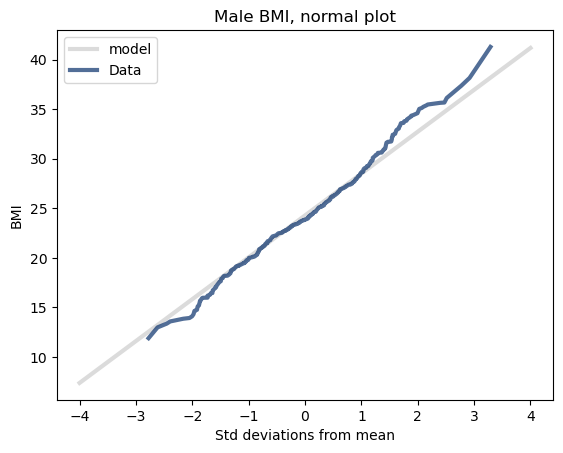

In [78]:
# Plotting Normal Probability plot for BMI of male_df
CreateNormalPlot(male_BMI)
thinkplot.Config(
    title="Male BMI, normal plot",
    xlabel="Std deviations from mean",
    ylabel="BMI",
    loc="upper left",
)

#####  ***Interpretation:*** From the Linear scale plot of BMI of male_df, it is apparent that the model fits well for most part except for some discrepany around 10th and 90th percentile range. similar results can be observed in the Normal plot where the model describes the distribution well within a few standard deviations from the mean but not around the tails.

Median of CDF is 22.590064173327928
Results from the Model: len(input_variable), mean, std, median  616 23.227431601360173 4.168704550843694 22.608988664541148


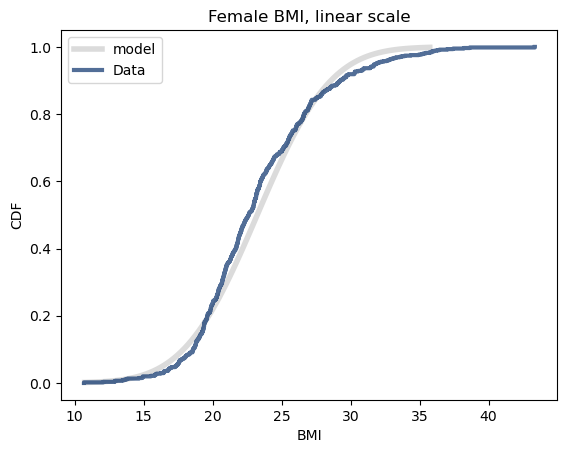

In [79]:
# Calculating the Normal Model of BMI of female_df
female_BMI=female_df.BMI
CreateNormalModel(female_BMI)
thinkplot.Config(
    title="Female BMI, linear scale",
    xlabel="BMI",
    ylabel="CDF",
    loc="upper left",
)

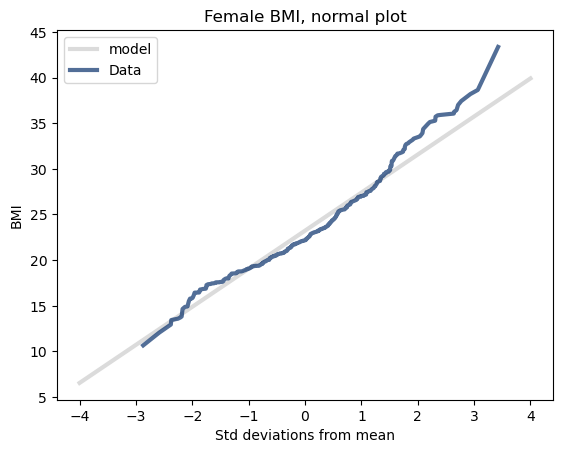

In [80]:
# Plotting Normal Probability plot for BMI of female_df
CreateNormalPlot(female_BMI)
thinkplot.Config(
    title="Female BMI, normal plot",
    xlabel="Std deviations from mean",
    ylabel="BMI",
    loc="upper left",
)

##### ***Interpretation:*** Unlike BMI of male_df, for the BMI of female_df the CDF data deviates to some extent from the Model data. The deviation from the model can be seen throughout and also in the Normal Prability plot. Hence, we will take log10 scale of the BMI to scale and plot the results.

Median of CDF is 1.35391746465576
Results from the Model: len(input_variable), mean, std, median  616 1.359263148891028 0.07604766734803342 1.3542809839687249


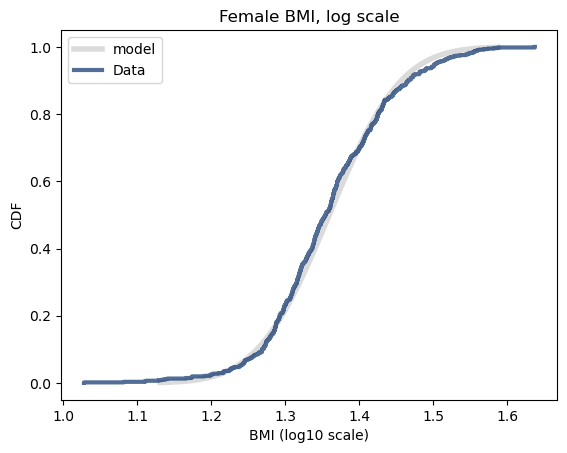

In [81]:
# Calculating the Normal Model of BMI of female_df of Log scale
log_female_BMI = np.log10(female_BMI)
CreateNormalModel(log_female_BMI)
thinkplot.Config(
    title="Female BMI, log scale",
    xlabel="BMI (log10 scale)",
    ylabel="CDF",
    loc="upper left",
)

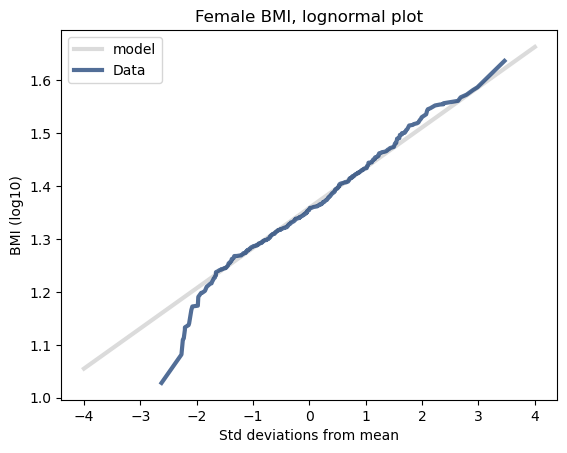

In [82]:
# Plotting Normal Probability plot for BMI of female_df of log10 scale
CreateNormalPlot(log_female_BMI)
thinkplot.Config(
    title="Female BMI, lognormal plot",
    xlabel="Std deviations from mean",
    ylabel="BMI (log10)",
    loc="upper left",
)

##### ***Interpretation:*** The result from log Normal plot of BMI of female_df looks lot closer to the model compared to the linear scale. Though there are some deviations around the tails, this will be a better fit compared to linear scale. This suggests that the lognormal model describes the distribution much better within a few standard deviations from the mean but not so much around the tails.

Median of CDF is 174.2
Results from the Model: len(input_variable), mean, std, median  600 173.76037414965987 8.58862825101667 174.2


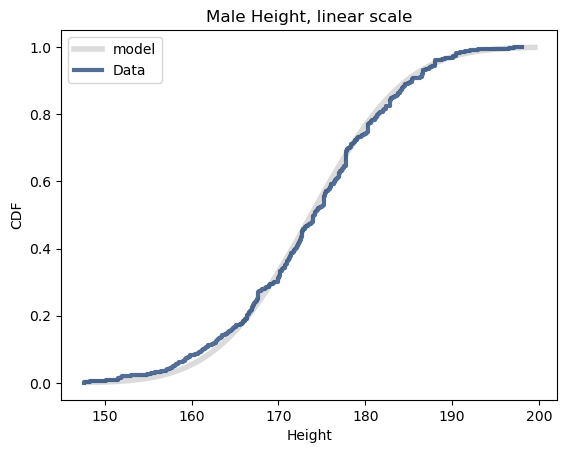

In [83]:
# Calculating the Normal Model ofheight of male_df
male_hgt=male_df.hgt
CreateNormalModel(male_hgt)
thinkplot.Config(
    title="Male Height, linear scale",
    xlabel="Height",
    ylabel="CDF",
    loc="upper left",
)


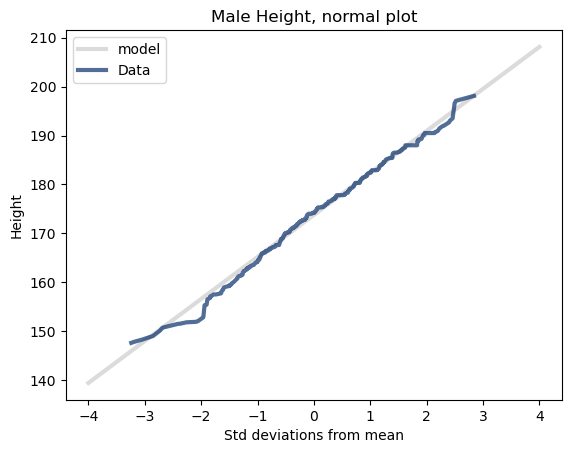

In [84]:
# Plotting Normal Probability plot for height of male_df 
CreateNormalPlot(male_hgt)
thinkplot.Config(
    title="Male Height, normal plot",
    xlabel="Std deviations from mean",
    ylabel="Height",
    loc="upper left",
)

##### ***Interpretation:*** The results of the normal probability plot and the linear scale model suggests that the NOrmal model is a better fit for the Heights data though there can be some deviations around the tails, especially at the bottom part.

### Question 8

#### Create two scatter plots comparing two variables and provide your analysis on correlation and causation. Remember, covariance, Pearson’s correlation, and Non-Linear Relationships should also be considered during your analysis (Chapter 7).

##### ***Approach:*** To find the relationship between the variables, we first plot the scatter plot with a fitted line to check if the relationship is linear. We also plot Percentile plot to find the relationship at different Percentile levels. Finally, we measure the Correlation using Pearson and Spearman methods

In [85]:
def create_ScatterPlot(var1, var2,xlabel,ylabel,xlim,ylim,title):
    """
    This function will create Scatter plot of two variables.
    var1, var2: Sequence of two variables that are plotted.
    xlabel,ylabel,xlim,ylim,title: Attributes used while plotting
    """
    # Intercept and slope of the line is calculated using the LeastSquares function.
    inter, slope = thinkstats2.LeastSquares(var1, var2)
    # line is fit in the plot
    fxs, fys = thinkstats2.FitLine(var1, inter, slope)
    # Plotting the Scatter plot
    thinkplot.Scatter(var1, var2, alpha=0.5, s=20)
    thinkplot.Plot(fxs, fys, color='red')
    thinkplot.Config(xlabel=xlabel,
                         ylabel=ylabel,
                         xlim=xlim,
                         ylim=ylim,
                         title=title,
                         legend=True)


In [86]:
def Jitter(values, jitter=0.5):
    """
    This function will create jitter to avoid errors due to rounding of the data
    """
    val_len = len(values)
    # Adding normal values and adding to the original value
    return np.random.normal(0, jitter, val_len) + values

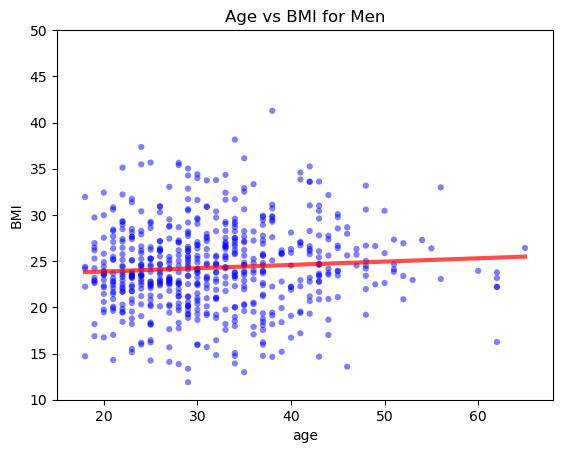

In [87]:
# Scatter plot of Age vs BMI of male_df
age_m=male_df['age']
BMI_m=male_df['BMI']
create_ScatterPlot(age_m,BMI_m,xlabel='age',ylabel='BMI',xlim=[15,68],ylim=[10,50],title='Age vs BMI for Men')

##### ***Interpretation:*** The scatter plot indicates a weak linear relationship between Age and BMI. However we see vertical lines for the age which maybe because of rounding of the data. Hence we add a jitter of 0.5 to avoid the rounding effect.

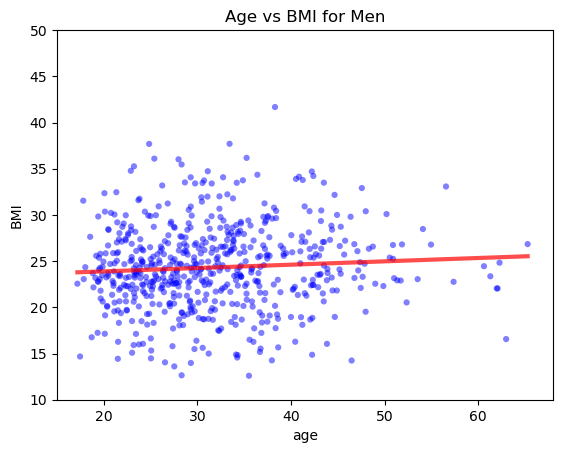

In [88]:
# Adding Jitter of 0.5 to both Age and BMI to avoid the effects due to rounding of numbers
# Jitter of 0.5 is added to  represent the rounding could be 0.5 or -0.5
age_m_jitter = Jitter(age_m, 0.5)
BMI_m_jitter = Jitter(BMI_m, 0.5)
# Creating Scatter plot on jitter data
create_ScatterPlot(age_m_jitter,BMI_m_jitter,xlabel='age',ylabel='BMI',xlim=[15,68],ylim=[10,50],title='Age vs BMI for Men')

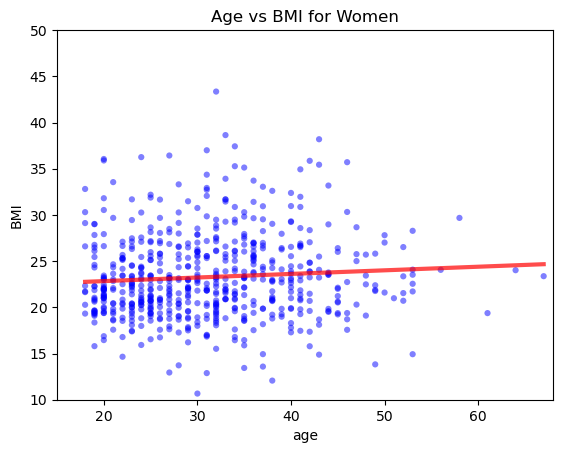

In [89]:
# Scatter plot of Age vs BMI of female_df
age_f=female_df['age']
BMI_f=female_df['BMI']
create_ScatterPlot(age_f,BMI_f,xlabel='age',ylabel='BMI',xlim=[15,68],ylim=[10,50],title='Age vs BMI for Women')

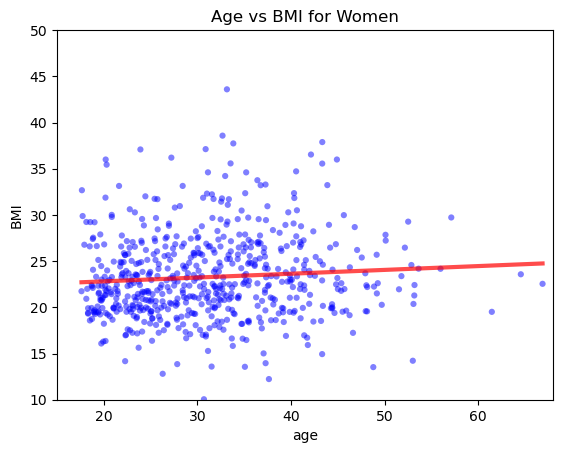

In [90]:
# Adding Jitter of 0.5 to both Age and BMI to avoid the effects due to rounding of numbers
age_f_jitter = Jitter(age_f, 0.5)
BMI_f_jitter = Jitter(BMI_f, 0.5)
# Creating Scatter plot on jitter data
create_ScatterPlot(age_f_jitter,BMI_f_jitter,xlabel='age',ylabel='BMI',xlim=[15,68],ylim=[10,50],title='Age vs BMI for Women')

##### ***Interpretation:*** The scatter plot of female_df also had similar issues due to rounding, hence jitter was added back to the data and results were plotted. The results still indicates a weak linear relation between the Age and BMI for both Men and Women.

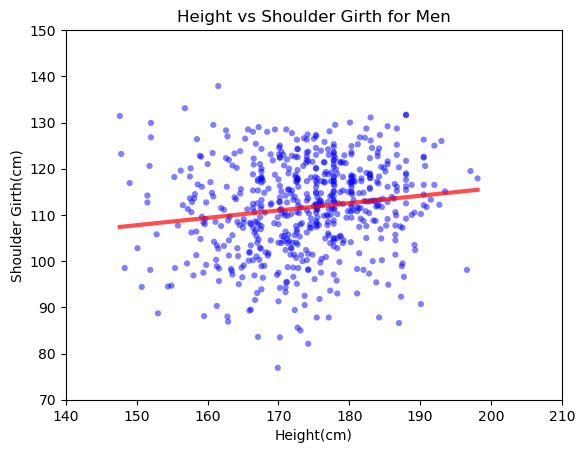

In [91]:
# Scatter plot of Height vs Shoulder Girth of male_df
sho_m=male_df['sho_gi']
hgt_m=male_df['hgt']
create_ScatterPlot(hgt_m,sho_m,xlabel='Height(cm)',ylabel='Shoulder Girth(cm)',xlim=[140,210],ylim=[70,150],title='Height vs Shoulder Girth for Men')

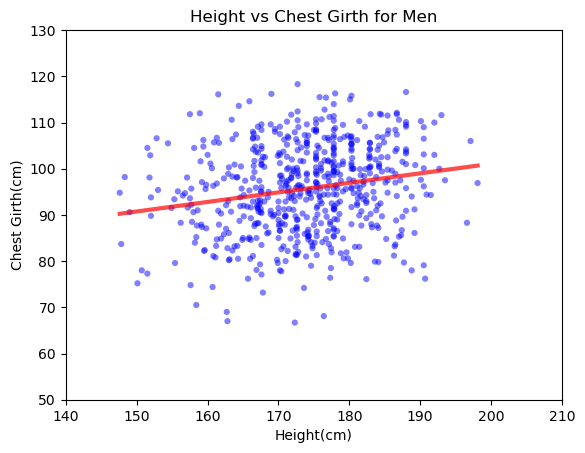

In [92]:
# Scatter plot of Height vs Chest Girth of male_df
che_m=male_df['che_gi']
hgt_m=male_df['hgt']
create_ScatterPlot(hgt_m,che_m,xlabel='Height(cm)',ylabel='Chest Girth(cm)',xlim=[140,210],ylim=[50,130],title='Height vs Chest Girth for Men')

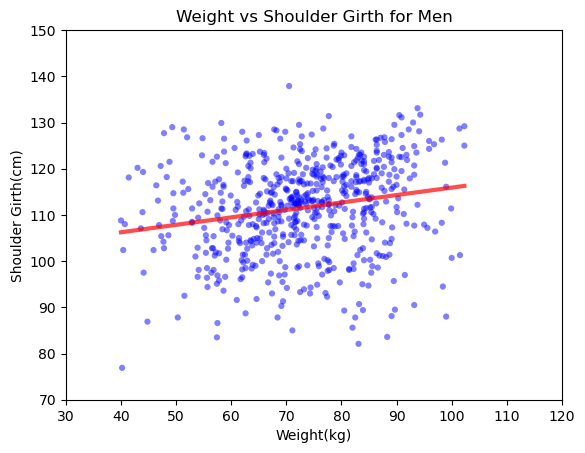

In [93]:
# Scatter plot of Weight vs Shoulder Girth of male_df
wgt_m=male_df['wgt']
create_ScatterPlot(wgt_m,sho_m,xlabel='Weight(kg)',ylabel='Shoulder Girth(cm)',xlim=[30,120],ylim=[70,150],title='Weight vs Shoulder Girth for Men')

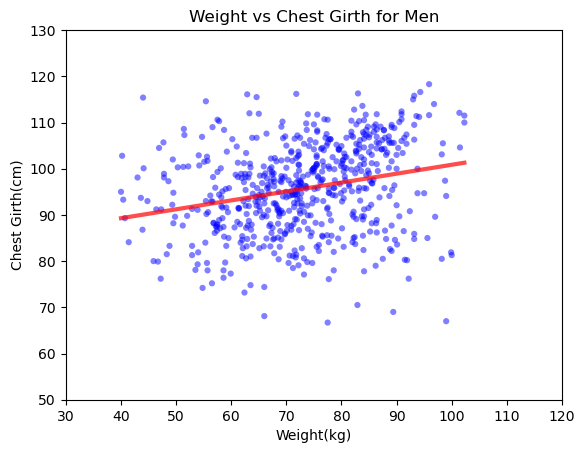

In [94]:
# Scatter plot of Weight vs Chest Girth of male_df
create_ScatterPlot(wgt_m,che_m,xlabel='Weight(kg)',ylabel='Chest Girth(cm)',xlim=[30,120],ylim=[50,130],title='Weight vs Chest Girth for Men')

##### ***Interpretation:*** All the  4 Scatter plots above indicates a positive relationship. For instance, as the height or weight of the Men increases, they tend to have broader shoulders and bigger chest, though there are many outliers in the data as well.

In [95]:
def plot_Percentile(df,var1,var2,bin_low,bin_high,binwidth,xlabel,ylabel,axis,title):
    """
    This function will plot Percentile plot at 25, 50 and 75 percentile for the input variables.
    df: The Input Dataframe
    var1,var2: The Input Variables of which the percentile will be plot for percentile of var2 for a 
    range of  var1 bins.
    bin_low,bin_high, binwidth: Specifications for plotting the bins.
    xlabel, ylabel, axis, title: Attributes for the Plot
    """
    # Plotting the bin in the increments of binwidth
    bins = np.arange(bin_low, bin_high,binwidth)
    # Computing the index of the bin that contains the value in df
    indices = np.digitize(df[var1], bins)
    # Creating groups based on indices
    groups = df.groupby(indices)
    # Computing the mean of var1 for each group. This will be used in plotting x-axis
    mean_var1 = [group[var1].mean() for i, group in groups]
    # Creating CDF of var2 for each group
    cdfs = [thinkstats2.Cdf(group[var2]) for i, group in groups]
    # Plotting the data for each percentile
    for percent in [75, 50, 25]:
        # The value of percentiles are stored in var2_percentiles
        var2_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        # Plotting Percentile Plot
        thinkplot.Plot(mean_var1, var2_percentiles, label=label)
    thinkplot.Config(xlabel=xlabel,
                     ylabel=ylabel,
                     axis=axis,
                     title=title,
                     legend=True)

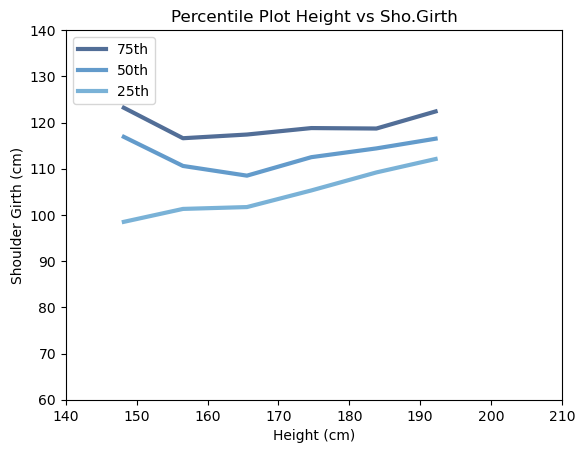

In [96]:
# Percentile plot of Height vs Shoulder Girth of male_df
plot_Percentile(male_df,var1='hgt',var2='sho_gi',bin_low=140,bin_high=210,binwidth=10,xlabel='Height (cm)',ylabel='Shoulder Girth (cm)'
                ,title='Percentile Plot Height vs Sho.Girth',axis=[140,210,60,140])

##### ***Interpretation:*** The Percetile plot of Height vs Shoulder Girth indicates that the relationship is not entirely linear. Between 165 to 200 cm, the relationship in close to linear, however not so much around the tails between 145 to 165 cm. 

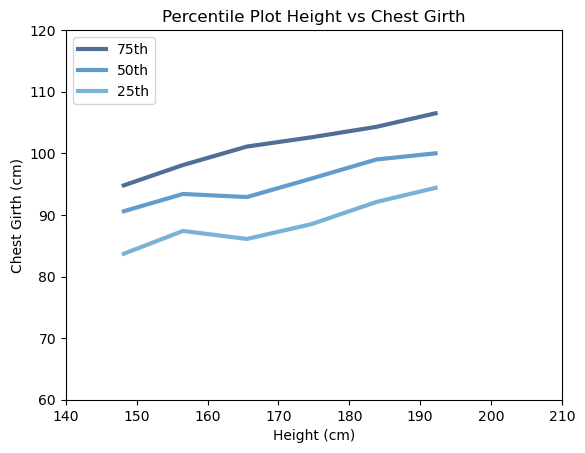

In [97]:
# Percentile plot of Height vs Chest Girth of male_df
plot_Percentile(male_df,var1='hgt',var2='che_gi',bin_low=140,bin_high=210,binwidth=10,xlabel='Height (cm)',ylabel='Chest Girth (cm)'
                ,title='Percentile Plot Height vs Chest Girth',axis=[140,210,60,120])

##### ***Interpretation:*** The Percetile plot of Height vs Chest girth paints a similar picture where the relation is not entirely linear, however between it appears linear between 170 to 195 cm of height

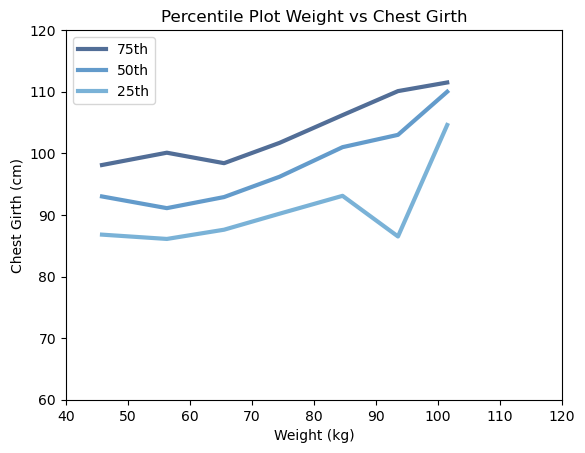

In [98]:
# Percentile plot of Weight vs Chest Girth of male_df
plot_Percentile(male_df,var1='wgt',var2='che_gi',bin_low=40,bin_high=120,binwidth=10,xlabel='Weight (kg)',ylabel='Chest Girth (cm)'
                ,title='Percentile Plot Weight vs Chest Girth',axis=[40,120,60,120])

##### ***Interpretation:*** The percentile plot of Weight vs Chest Girth of male_df indicates that the relation is non-linear for most part of the plot as there is no clear relation.

In [99]:
# Function to calculate Covariance. Covariance is the measure of how two variables vary together.
# To calculate the Covariance, we add up the product of their deviations from their mean.
def Cov(xs, ys, meanx=None, meany=None):
    """
    The function takes the arrays of x and y and their sample mean as inputs. 
    If mean is not provided it will be calculated in the function
    Returns the covariance.
    """
    # Converting the input to numpy array format
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    # If the means are not provided, they will be calculated
    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)
    # Covariance is calculated by using numpy dot function. It multiples the difference of each element in 
    # xs and ys array from their respective mean and sums them. 
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [100]:
def PearsonCorr(xs, ys):
    """
    Inputs are x and y arrays.
    Returns the Correlation between the two series.
    """
    # Converting the input to numpy array format
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    # Calculating the Mean and Variance of the two series and assigning to variables
    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)
    # Correlation is calculated by standardizing Covariance by the product of Std deviation of 2 input series.
    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [101]:
# Function to calculate Spearman Correlation. In this method we compute the ranks of each variable in the
# input array and compute the correlation between them.
def SpearmanCorr(xs, ys):
    """
    Function to calculate Spearman's correlation.
    Inputs are x and y series.
    Returns the Spearman correlation between the variables.
    """
    # Calculates the rank of each variables in the input series and creates series of Rank values
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    # Computes the correlation on the Rank series.
    return PearsonCorr(xranks, yranks)

In [102]:
# Pearson and Spearman correlation between Male Age and BMI
Cov(age_m,BMI_m),PearsonCorr(age_m,BMI_m),SpearmanCorr(age_m,BMI_m)

(2.7369915503370597, 0.0691673628342364, 0.08967049398278261)

#####  ***Interpretation:*** The differences in the results of Pearson and Spearman Correlation between Age and BMI may be due to below reasons:
##### 1. The Pearson may underestimate the correlation if some of the relationship is non-linear which is handled well by spearman method.
##### 2. Pearson correlation can be affected by the presence of outliers in the data, while Spearman can be robust in handling it since it uses ranks.

In [103]:
# Pearson and Spearman correlation between Female Age and BMI
Cov(age_f,BMI_f),PearsonCorr(age_f,BMI_f),SpearmanCorr(age_f,BMI_f)

(2.9670247893012007, 0.07511490744415468, 0.10198622130636682)

In [104]:
# Pearson and Spearman correlation between Male Height and Shoulder Girth

# Taking log of shoulder girth
log_sho_m=np.log(male_df['sho_gi'])
Cov(hgt_m,sho_m),PearsonCorr(hgt_m,sho_m),SpearmanCorr(hgt_m,sho_m),PearsonCorr(hgt_m,log_sho_m)


(13.243163666666662,
 0.1446740912207459,
 0.16960083569062775,
 0.14829709928882978)

##### ***Interpretation:*** Taking log value of Shoulder girth improves the Correlation between shoulder girth and height better than linear scale

In [105]:
# Pearson and Spearman correlation between Male Height and Chest Girth
PearsonCorr(hgt_m,che_m),SpearmanCorr(hgt_m,che_m)

(0.19596426071906392, 0.19985067187790764)

In [106]:
# Pearson and Spearman correlation between Male Weight and Shoulder Girth
PearsonCorr(wgt_m,sho_m),SpearmanCorr(wgt_m,sho_m)

(0.20117610599564426, 0.2269868569108273)

In [107]:
# Pearson and Spearman correlation between Male Weight and Chest Girth
# Taking log of Chest girth does not help with correlation, actually makes it less correlated.
log_che_m=np.log(male_df['che_gi'])
PearsonCorr(wgt_m,che_m),SpearmanCorr(wgt_m,che_m),PearsonCorr(wgt_m,log_che_m)

(0.25172404419773087, 0.2864742808949879, 0.239753040069293)

In [108]:
# Pearson and Spearman correlation between Female Weight and Waist Girth
wai_f=female_df['wai_gi']
wgt_f=female_df['wgt']
PearsonCorr(wgt_f,wai_f),SpearmanCorr(wgt_f,wai_f)

(0.26211605961897316, 0.3429749042500992)

### Question 9

#### Conduct a test on your hypothesis using one of the methods covered in Chapter 9.

#### ***Approach:*** To perform the Hypothesis testing, we use Parent class from Thinkstats2.py and create Abstract classes on top of it. The testing is done by comparing the difference between Mean values of two groups which is the actual mean. The Same experiment is repeated multiple times by resampling the data from both groups. The P-value is calculated by measuring the number of times the difference in the means of the sampled groups exceeds the actual mean. If the P-value is less than 0.05, which indicates the difference in mean is unlikely to occur by chance, we consider the test results to be statistically significant. The Null hypothesis for the testing is that there is no difference in mean between the groups.

#### We also follow similar approach by repeating the test by finding the difference in the standard deviation between the groups and comparing it to the actual value. Other way of perfoming the Hypothesis testing is by computing correlation between the two variables (which will be the actual value) and during hypothesis testing, we repeat the correlation test between the vraibles for different samples and measure the number of times the sample correlation is greater than actual correlation. From this the p-value is calculated which indicates if the correlation is statistically significant or not.

In [109]:
# Below is the HypothesisTest Class based on thinkstats2 module
class HypothesisTest_base(object):
    """
    An abstract lass that conducts Hypothesis test. Code is referenced from thinkstats2.
    """
    # This is the initial setup. whenever the class is invoked, this part will execute
    def __init__(self, input_data):
        self.input_data = input_data
        # Performs initial processing setup such as deriving array lengths., etc and builds a representation
        # of Null hypothesis.
        self.CreateModel()
        # Deriving actual value. This will be used for comparison while running hypothesis tests.
        self.actual_value = self.CreateTestStatistic(input_data)
        

    # This method computes the final PValue. 
    def calculate_PValue(self, iterations=1000):
        # This loops through the number of iterations and calls ExecuteModel module and collects results in a list
        self.model_outputs = [self.CreateTestStatistic(self.ExecuteModel()) for _ in range(iterations)]
        # This compares the actual value with each value in the test_stats list. If the test_stats value is greate
        # the result will be captured in the count variable.
        #print(self.actual_value)
        eligible_count = sum(1 for model_output in self.model_outputs if model_output >= self.actual_value)
        # The ratio of count to number of iterations is the P-Value
        #print(eligible_count / iterations)
        return eligible_count / iterations

    # Placeholder method for CreateTestStatistic. Raises exception if not defined
    def CreateTestStatistic(self, input_data):
        raise UnimplementedMethodException()

    # Placeholder method for MakeModel. 
    def CreateModel(self):
        pass
    
    # Placeholder method for RunModel. Raises exception if not defined
    def ExecuteModel(self):
        raise UnimplementedMethodException()

In [110]:
class HypothesisTest_Means(HypothesisTest_base):
    """
    This class is derived from HypothesisTest. The method used is by finding the difference between the 
    means of the two groups of input data. By simulating the test with various data samples, we can calculate
    the number of times the difference in the mean between the groups exceeds the original difference.
    If the difference is lesser than 5%, we reject the Null hypothesis and the result is 
    statistically significant.
    """
    # This computes the size of the effect in the sample.
    def CreateTestStatistic(self, input_data):
        # Split the input that has 2 groups and assign to variables
        input_data_1, input_data_2 = input_data
        # find the absolute value of difference between mean of two groups
        derived_test_stats = abs(input_data_1.mean() - input_data_2.mean())
        #print(f"derived_test_stats is {derived_test_stats}")
        return derived_test_stats

    # Creates a Model that will be used further in the Testing
    def CreateModel(self):
        # Split the input that has 2 groups and assign to variables
        input_data_1, input_data_2 = self.input_data
        # Compute the length of each group
        self.input_data_1_size, self.input_data_2_size = len(input_data_1), len(input_data_2)
        # Combine the data from both groups and create a single array 
        self.combined_datapool = np.hstack((input_data_1, input_data_2 ))

    # this will run the Model through multiple iterations and generate results for each run
    def ExecuteModel(self):
        # Shuffle the data in combined dataset
        np.random.shuffle(self.combined_datapool)
        # create sample data from combined pool with same dimensions as the original data.
        # We create 2 groups with lengths of input_data_1_size and input_data_2_size
        input_data = self.combined_datapool[:self.input_data_1_size], self.combined_datapool[self.input_data_1_size:]
        return input_data

In [111]:
class HypothesisTest_Correlation(HypothesisTest_base):
    """
    This class is derived from HypothesisTest. The method used is by finding the correlation between two groups of input data.
    By simulating the test with various data samples, we can calculate the number of times the correlation between the groups exceeds 
    the original corelation. If the count is lesser than 5%, we reject the Null hypothesis and the result is 
    statistically significant.
    """
    # This computes the size of the effect in the sample.
    def CreateTestStatistic(self, input_data):
         # Split the input that has 2 groups and assign to variables
        input_data_1, input_data_2 = input_data
        # find the absolute value of correlation between two groups
        derived_test_stats = abs(thinkstats2.Corr(input_data_1, input_data_2))
        return derived_test_stats

    def ExecuteModel(self):
        # Split the input that has 2 groups and assign to variables
        data_1,data_2 = self.input_data
        # Shuffle the first series and return the series to find the correlation between the shuffled data
        data_1 = np.random.permutation(data_1)
        return data_1,data_2

In [112]:
def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.
    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement
    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

In [113]:
def create_samples(df1,df2,sample_len=500):
    """
    This function creates samples of the dataframes by using SampleRows function from thinkstats module.
    df1,df2: INput dataframes which should be sampled
    sample_len: Number of samples to be used
    Returns the sampled dataframes df1 and df2 of desired length.
    """
    sample_df1 = SampleRows(df1, sample_len)
    sample_df2 = SampleRows(df2, sample_len)
    return sample_df1,sample_df2

In [114]:
# Calculating the mean of BMI of male and female.
male_df.BMI.mean(),female_df.BMI.mean()
# The results indicate that the Men have higher BMI compared to women. 
# Let us explore this by conducting hypothesis testing based on mean by resampling the data over multiple iterations.

(24.294980075802002, 23.272709734370572)

In [115]:
# Running Hypothesis test based of mean of BMI between male and female df
# Creating male and female df samples of length 500
sample_male_df,sample_female_df=create_samples(male_df,female_df)
input_BMI = sample_male_df.BMI.values, sample_female_df.BMI.values
# Running the hypothesis test on means
BMI_hyptest = HypothesisTest_Means(input_BMI)
# Calculating the P-value
pvalue_BMI_mean = BMI_hyptest.calculate_PValue()
pvalue_BMI_mean

0.001

##### ***Interpretation:*** After running the Hypothesis test on mean values of BMI for 1000 times, the p-value is much lower than 0.05 which indicates the difference in the BMI of Men and Women are statistically significant

In [116]:
# Running Hypothesis test based of mean of BMI between Young male and female df
sample_youngmale_df,sample_youngfemale_df=create_samples(young_male_df,young_female_df,sample_len=200)
young_BMI = young_male_df.BMI.values, young_female_df.BMI.values
young_BMI_hyptest = HypothesisTest_Means(young_BMI)
young_pvalue_BMI_mean = young_BMI_hyptest.calculate_PValue()
young_pvalue_BMI_mean

0.0

##### ***Interpretation:*** After running the Hypothesis test on mean values of BMI for 1000 times, the p-value is much lower than 0.05 which indicates the difference in the BMI of Young Men and Women are statistically significant and is unlikely to occur by chance.

In [117]:
class mean_hyptest_OneSided(HypothesisTest_Means):
# This calculates the One sided Mean without taking the absolute value of differences between the meansof 2 groups.
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

In [118]:
# Running Hypothesis test based of one sided mean of BMI between male and female df
BMI_hyptest_oneside = mean_hyptest_OneSided(input_BMI)
pvalue_BMI_onesided = BMI_hyptest_oneside.calculate_PValue()
pvalue_BMI_onesided

0.0

In [119]:
# Running Hypothesis test based of mean of Shoulder Girth between male and female df
# Creating male and female df samples of length 500
sample_male_df,sample_female_df=create_samples(male_df,female_df)
input_shogi = sample_male_df.sho_gi.values, sample_female_df.sho_gi.values
# Performing Hypothesis test based on Mean
shogi_hyptest = HypothesisTest_Means(input_shogi)
pvalue_shogi_hyptest  = shogi_hyptest.calculate_PValue()
pvalue_shogi_hyptest

0.0

In [120]:
# Creating male and female df samples of length 200
sample_healthymale_df,sample_healthyfemale_df=create_samples(healthy_male_df,healthy_female_df,250)
healthy_BMI = sample_healthymale_df.BMI.values, sample_healthyfemale_df.BMI.values
healthy_BMI_hyptest_oneside = mean_hyptest_OneSided(healthy_BMI)
pvalue_healthy_BMI_onesided = healthy_BMI_hyptest_oneside.calculate_PValue()
pvalue_healthy_BMI_onesided

0.0

##### ***Interpretation:*** Both the results of Hypothesis testing  suggest the results are statistically significant as the values are much lesser than 0.05 and is unlikely to occur by chance. For example, the Young men have higher BMI on average compared to women and the Hypothesis testing results suggest that the difference is significant.

In [121]:
class std_hyptest(HypothesisTest_Means):
    # Creating Hypothesis test by calculating Standard deviation
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [122]:
# Creating male and female df samples of length 500
sample_male_df,sample_female_df=create_samples(male_df,female_df)
input_BMI = sample_male_df.BMI.values, sample_female_df.BMI.values
BMI_hyptest_std = std_hyptest(input_BMI)
pvalue_BMI_hyptest_std = BMI_hyptest_std.calculate_PValue()
pvalue_BMI_hyptest_std

0.0

##### ***Interpretation:*** The results of Hypothesis testing by calculating standard deviation of BMI of male and female df  suggest the results are statistically significant as the values are much lesser than 0.05

In [123]:
# Hypothesis test based on Correlation between age and BMI of male_df

# Creating samples by picking 500 samples from dataset
sample_male_df = SampleRows(male_df, 500)
corr1_input=sample_male_df.age.values,sample_male_df.BMI.values
# Performing Hypothesis test based on Corelation
corr1_hyptest = HypothesisTest_Correlation(corr1_input)
# Calculating the P-value
pvalue_corr1_hyptest = corr1_hyptest.calculate_PValue()
pvalue_corr1_hyptest

0.075

##### ***Interpretation:*** The results of correlation between age and BMI of male_df suggests that the Correlation is not statistically significant as the P-Value is greater than 0.05 and the correlation results may be due to chance.

In [124]:
# Hypothesis test based on Correlation between age and BMI of female_df
# Creating samples by picking 500 samples from dataset
sample_female_df = SampleRows(female_df, 500)
corr2_input=sample_female_df.age.values,sample_female_df.BMI.values
corr2_hyptest = HypothesisTest_Correlation(corr2_input)
pvalue_corr2_hyptest = corr2_hyptest.calculate_PValue()
pvalue_corr2_hyptest

0.065

##### ***Interpretation:*** The results of correlation between age and BMI of female_df suggests that the Correlation is not statistically significant as the P-Value is greater than 0.05

In [125]:
# Creating samples by picking 500 samples from dataset
sample_male_df = SampleRows(male_df, 500)
corr3_input=sample_male_df.hgt.values,sample_male_df.sho_gi.values
corr3_hyptest = HypothesisTest_Correlation(corr3_input)
pvalue_corr3_hyptest = corr3_hyptest.calculate_PValue()
pvalue_corr3_hyptest

0.0

In [126]:
# Creating samples by picking 500 samples from dataset
sample_male_df = SampleRows(male_df, 500)
corr4_input=sample_male_df.wgt.values,sample_male_df.che_gi.values
corr4_hyptest = HypothesisTest_Correlation(corr4_input)
pvalue_corr4_hyptest = corr4_hyptest.calculate_PValue()
pvalue_corr4_hyptest

0.0

In [127]:
# Creating samples by picking 500 samples from dataset
sample_female_df = SampleRows(female_df, 500)
corr5_input=sample_female_df.wgt.values,sample_female_df.wai_gi.values
corr5_hyptest = HypothesisTest_Correlation(corr5_input)
pvalue_corr5_hyptest = corr5_hyptest.calculate_PValue()
pvalue_corr5_hyptest

0.0

#####  ***Interpretation:***All the P-value results from above correlation between shoulder girth-height, chest girth-weight and waist girth- weight suggests that correlation is statistically significant as they are less than 0.05. Per the results from the previous section, these variables have positive correlation between them and they are all expected to be significant and not likely due to chance. So they all help us to conclude that Men in general are heavier than women due to Higher values of BMI. Men are taller and heavier than women per these tests. Also, men are likely to have broader shoulders compared to women.

### Question 10

#### For this project, conduct a regression analysis on either one dependent and one explanatory variable, or multiple explanatory variables (Chapter 10 & 11).

##### ***Approach:*** OLS(Ordinary Least Squares) function from statsmodel package will be used to create the Regression model. All the variables that were discussed so far will be used to find the regression between them. The  variables are represented in patsy syntax. the operator on the left is the dependent variable and the explanatory variable is on the right

In [128]:
# Creating Regression model of Chest girth ~ Height in Body measure df
formula1 = 'che_gi ~ hgt'
# The function returns OLS object which represents the model
model1 = smf.ols(formula1, data=body_measures_df)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 che_gi   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     57.45
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           6.86e-14
Time:                        19:28:24   Log-Likelihood:                -4484.2
No. Observations:                1216   AIC:                             8972.
Df Residuals:                    1214   BIC:                             8983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     55.2944      4.992     11.077      0.000      45.501      65.088
hgt            0.2207      0.029      7.579      0.000       0.164       0.278
==============================================================================
Omnibus:                       12.887   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.813
Skew:                           0.120   Prob(JB):                      0.00740
Kurtosis:                       2.631   Cond. No.                     3.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ***Interpretation:***  The results represent the R squared of 0.04 which is not a strong relation, however p-values are almost 0 which represents the results are statistically significant and they are unlikely to occur by chance.

In [129]:
# Creating Regression model of Chest girth ~ Height in Body measure df by adding additional 
# variables such as height**2 and also filtering only for Male
formula2 = 'che_gi ~ hgt + hgt**2+sex==1'
model2 = smf.ols(formula2, data=body_measures_df)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 che_gi   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     58.54
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           5.36e-25
Time:                        19:28:24   Log-Likelihood:                -4456.3
No. Observations:                1216   AIC:                             8919.
Df Residuals:                    1213   BIC:                             8934.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           63.4507      4.999     12.693      0.000      53.643      73.258
sex == 1[T.True]     4.2521      0.563      7.549      0.000       3.147       5.357
hgt                  0.1608      0.030      5.441      0.000       0.103       0.219
==============================================================================
Omnibus:                        5.813   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.637
Skew:                           0.135   Prob(JB):                       0.0597
Kurtosis:                       2.805   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ***Interpretation:*** The results of the regression model with additional variables such as height**2 and including only men improves the value of R2 to 0.087. The height**2 are added since the relation may be partly non-linear. The P-Values are also statistically significant which means the results were unlikely to occur by chance. However comparing the regression results from above indicates that the coef of height has gone down from 0.22 to 0.16 in the new model. The sex==1 (filter for men) does a better job in predicting chest girth compared to heights.

In [130]:
# Using Data mining function to identify Explanatory variables
def create_Mining(join_df,fieldname):
    """Searches for each variable in the dataframe and performs ordinary least squares test.
    join_df: Source dataframe in which each variables is tested.
    fieldname: The dependent variable.
    returns: list of (rsquared, variable name) pairs
    """
    # creating a list to store all the R2 results of each variable
    all_fields_R2 = []
    # Iterate through each column in the source dataframe
    for name in join_df.columns:
        # Using try and except clause to catch exception while calculating variance on non-numeric fields
        try:
            # Excluding columns that have very small variance as they may not be significant.
            if join_df[name].var() < 1e-7:
                continue
            # Creating formula used in regression. The fieldname is the dependent variable and "name" is
            # the explanatory variable. This will be iterated for each column in the dataframe.
            formula = fieldname +' ~ + ' + name
            # Using statsmodel.formula.api to calculate the ordinary least squares
            model = smf.ols(formula, data=join_df)
            # if number of observations is lesser than half the length of dataframe ignore the column. 
            # This check is essential to ignore the columns with many NaNs
            if model.nobs < len(join_df)/2:
                continue
            # This will store the results of the model in results variable
            results = model.fit()
        # To catch exceptions while performing variance on non-numeric columns
        except (ValueError, TypeError, patsy.PatsyError) as e:
            continue
        # After each loop the results of the R2 and the column names are added back to all_fields_R2 list
        all_fields_R2.append((results.rsquared, name))
    return all_fields_R2

In [131]:
  def create_regression(df,colname):
    """
    This  function creates linear regression by calling the create mining function.
    df: Dataframe in which the column exists
    colname: The colum for which all other variables in the dataframe are analyzed to find the variables
    with highest R2.
    """
    all_fields_R2 = create_Mining(df,colname)
    # Sort the results so that the top few columns with significant R2 will be considered for analysis
    all_fields_R2.sort(reverse=True)
    # Pring the top 50 results from all_fields_R2
    for rsq,col in all_fields_R2[:20]:
        print(rsq,col)

In [132]:
# Running Regression function to identify the variables that have highest R2 values
create_regression(male_df,'BMI')

1.0 BMI
0.6630597740856469 wgt
0.1608673702959289 hgt
0.033824939194778136 for_gi
0.03153335959992565 hip_gi
0.03020031617542973 thi_gi
0.027857361555046145 wai_gi
0.024775755201122296 bic_gi
0.02240908259758212 kne_gi
0.017139161158123195 ank_gi
0.016389746095843316 kne_di
0.015550798234183372 elb_di
0.0129414177253665 bit_di
0.012402819027417245 nav_gi
0.011804726429203383 che_de
0.011449843540718319 cal_gi
0.011280229098265981 ank_di
0.010891076260361787 che_gi
0.008103056622654758 sho_gi
0.005976520550412423 bii_di


In [133]:
# Building Regression model for BMI in Male_df
# The variables wgt, height,ches depth wrist girth are chosen to build the model
model_male_BMI = smf.ols('BMI ~  wgt + hgt+ che_di + wri_gi + age + nav_gi', data=male_df)
# The results are then fit and summary method is called to describe the statistics
results_model_male_BMI = model_male_BMI.fit()
results_model_male_BMI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BMI   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     9416.
Date:                Thu, 27 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:28:24   Log-Likelihood:                -366.68
No. Observations:                 584   AIC:                             747.4
Df Residuals:                     577   BIC:                             778.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.9603      0.438    116.239      0.000      50.099      51.821
wgt            0.3362      0.002    213.093      0.000       0.333       0.339
hgt           -0.2872      0.002   -134.014      0.000      -0.291      -0.283
che_di        -0.0136      0.007     -1.872      0.062      -0.028       0.001
wri_gi        -0.0445      0.015     -2.998      0.003      -0.074      -0.015
age           -0.0006      0.002     -0.279      0.781      -0.005       0.004
nav_gi        -0.0018      0.002     -0.831      0.406      -0.006       0.003
==============================================================================
Omnibus:                      261.667   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1579.209
Skew:                           1.903   Prob(JB):                         0.00
Kurtosis:                      10.100   Cond. No.                     4.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ***Interpretation:*** The above Regression model does not much sense to this project because BMI is actually a derived field from Heights and weights. However the purpose of the demostration is to show how the Regression model can be used to prove the theory that BMI can be entirely constructed based on the values of Weight, height and other variables in the dataset. The R2 is 0.99 which is almost perfect model with P-values much lesser for weight and height indicating they are statistically significant.

In [134]:
# Running Regression function to identify the variables that have highest R2 values
create_regression(male_df,'sho_gi')

1.0 sho_gi
0.0745053423356794 for_gi
0.07086639983100274 elb_di
0.06709425739796082 bic_gi
0.06304287372939477 wai_gi
0.05756507794591126 wri_di
0.05473486080031331 che_gi
0.04721980223379885 che_di
0.045453446618387794 wri_gi
0.04266497519941148 bia_di
0.0425550304485548 ank_gi
0.040471825623570545 wgt
0.03038558662096258 che_de
0.02706959524743613 bit_di
0.024237930171769895 nav_gi
0.02333866746497848 cal_gi
0.022823803612624594 kne_di
0.021117723120186116 ank_di
0.020930592670548642 hgt
0.017337977335594723 kne_gi


In [135]:
# Building Regression model for Shoulder Girth in Male_df
# The variables Foreceps girth, Biceps girth ,elbow girth, waist girth, wrist diameter are chosen to build the model
model_male_sho_gi = smf.ols('sho_gi ~  for_gi + bic_gi+ elb_di + wai_gi + wri_di  + wgt + ank_di', data=male_df)
# The results are then fit and summary method is called to describe the statistics
results_model_male_sho_gi = model_male_sho_gi.fit()
results_model_male_sho_gi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sho_gi   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     17.23
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           1.02e-20
Time:                        19:28:24   Log-Likelihood:                -2082.0
No. Observations:                 572   AIC:                             4180.
Df Residuals:                     564   BIC:                             4215.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     47.4050      6.570      7.215      0.000      34.500      60.310
for_gi         0.4973      0.162      3.071      0.002       0.179       0.815
bic_gi         0.3408      0.099      3.458      0.001       0.147       0.534
elb_di         0.9999      0.328      3.048      0.002       0.356       1.644
wai_gi         0.1140      0.042      2.714      0.007       0.031       0.197
wri_di         1.1528      0.490      2.352      0.019       0.190       2.116
wgt            0.0384      0.034      1.119      0.264      -0.029       0.106
ank_di         0.1184      0.314      0.377      0.706      -0.498       0.735
==============================================================================
Omnibus:                        7.335   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                7.799
Skew:                          -0.205   Prob(JB):                       0.0203
Kurtosis:                       3.400   Cond. No.                     2.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ***Interpretation:*** The results of Regression model of shoulder girth has a R2 of 0.17 which is pretty good and most of the variables except for wgt and ank_di have a p-value much lesser than 0.05 indicating they are statistically significant in identifying the shoulder girth in men.

In [136]:
create_regression(body_measures_df,'hgt')

1.0 hgt
0.10528523755164998 BMI
0.08225664338542116 wri_di
0.07209960875632404 sex
0.07173415468643263 bia_di
0.07089507436197773 wgt
0.06757349050330985 wri_gi
0.059107171319887075 elb_di
0.051205628662476466 che_di
0.04855684794500459 for_gi
0.04589550244135632 ank_di
0.04518263431008673 che_gi
0.04489232467495485 ank_gi
0.04029585873939656 wai_gi
0.03851368562171609 kne_di
0.03731790131924195 bic_gi
0.0359220538664663 sho_gi
0.035632939908473604 che_de
0.03509229515716883 kne_gi
0.028659835911519327 cal_gi


In [137]:
model_female_hgt = smf.ols('hgt ~  wri_di + bia_di + wgt + wri_di + sex==0 + elb_di + che_gi', data=body_measures_df)
# The results are then fit and summary method is called to describe the statistics
results_model_female_hgt = model_female_hgt.fit()
results_model_female_hgt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hgt   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     39.39
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           8.26e-44
Time:                        19:28:25   Log-Likelihood:                -4251.2
No. Observations:                1187   AIC:                             8516.
Df Residuals:                    1180   BIC:                             8552.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          123.6345      4.671     26.468      0.000     114.470     132.799
sex == 0[T.True]    -2.2071      0.564     -3.915      0.000      -3.313      -1.101
wri_di               1.4645      0.299      4.902      0.000       0.878       2.051
bia_di               0.3896      0.093      4.186      0.000       0.207       0.572
wgt                  0.0863      0.022      3.908      0.000       0.043       0.130
elb_di               0.5407      0.211      2.561      0.011       0.127       0.955
che_gi               0.0522      0.029      1.829      0.068      -0.004       0.108
==============================================================================
Omnibus:                        1.967   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                2.004
Skew:                           0.098   Prob(JB):                        0.367
Kurtosis:                       2.955   Cond. No.                     2.30e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ***Interpretation:*** To build Regression model for Height, we exclude BMI which is a derived variable and consider other variables that have better R2. The resulting model has a better R2 of 0.16 and most of the variables in the model summary have lesser p-value indicating the results are statistically significant.

In [138]:
create_regression(body_measures_df,'wgt')

1.0 wgt
0.670912372099431 BMI
0.11723805196706794 for_gi
0.11318116398350853 bic_gi
0.11248180578171363 sho_gi
0.11233449793861217 che_gi
0.11217319152120186 kne_di
0.1037463238090498 wai_gi
0.0966683573394631 wri_di
0.0923563197032039 ank_gi
0.08791023456163727 kne_gi
0.08701548140915216 elb_di
0.08163038056550276 hip_gi
0.08136638762825299 che_di
0.08105047690004563 che_de
0.07582153794591784 sex
0.07484947796450214 wri_gi
0.07480251800801485 cal_gi
0.07355573518578284 bit_di
0.07089507436197784 hgt


In [139]:
model_male_wgt = smf.ols('wgt ~  wai_gi + che_gi + for_gi + kne_di + bic_gi + sho_gi + wri_gi +sex==1 ', data=body_measures_df)
# The results are then fit and summary method is called to describe the statistics
results_model_male_wgt = model_male_wgt.fit()
results_model_male_wgt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wgt   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     57.10
Date:                Thu, 27 Jun 2024   Prob (F-statistic):           1.69e-78
Time:                        19:28:25   Log-Likelihood:                -4452.0
No. Observations:                1170   AIC:                             8922.
Df Residuals:                    1161   BIC:                             8968.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -32.5722      5.913     -5.508      0.000     -44.174     -20.970
sex == 1[T.True]     1.6453      0.705      2.333      0.020       0.262       3.029
wai_gi               0.1567      0.034      4.594      0.000       0.090       0.224
che_gi               0.1494      0.037      4.028      0.000       0.077       0.222
for_gi               0.4625      0.126      3.658      0.000       0.214       0.711
kne_di               1.6260      0.254      6.393      0.000       1.127       2.125
bic_gi               0.3625      0.084      4.301      0.000       0.197       0.528
sho_gi               0.1400      0.035      3.953      0.000       0.070       0.209
wri_gi               0.3775      0.257      1.470      0.142      -0.126       0.881
==============================================================================
Omnibus:                       21.014   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.228
Skew:                           0.183   Prob(JB):                     2.73e-07
Kurtosis:                       3.697   Cond. No.                     3.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### ***Interpretation:*** For the regression model of Weight, we exclude the BMI which is again a derived variable. The result of model has a much better R2 of 0.28 which indicates good predicting power and most of the variables(except wri_gi) have lower p-values indicating the result is statistically significant.

In [140]:
# Logistic Regression to identify the likelihood of a person being Male given the body measurements 
# we add a new field called male to Body_measures_df
body_measures_df['male'] = (body_measures_df.sex==1).astype(int)


In [141]:
# Building a Logistic regression model using logit function from statsmodel package
logis_model1 = smf.logit('male ~ che_gi', data=body_measures_df)
logis_results1 = logis_model1.fit()
logis_results1.summary()

Optimization terminated successfully.
         Current function value: 0.659259
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   male   No. Observations:                 1216
Model:                          Logit   Df Residuals:                     1214
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:                 0.04877
Time:                        19:28:25   Log-Likelihood:                -801.66
converged:                       True   LL-Null:                       -842.76
Covariance Type:            nonrobust   LLR p-value:                 1.227e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.1280      0.589     -8.705      0.000      -6.283      -3.973
che_gi         0.0548      0.006      8.703      0.000       0.042       0.067
==============================================================================
"""

##### ***Interpretation:*** In Logistic regression, we use Pseudo R-squared to find the strength of the model which in this case in 0.04 with p-values much smaller indicating they are statistically significant

In [142]:
# Building a Logistic regression model using logit function from statsmodel package using additional variables
logis_model2 = smf.logit('male ~ che_gi+sho_gi+age+BMI+bia_di+bic_gi+hgt+wgt', data=body_measures_df)
logis_results2 = logis_model2.fit()
logis_results2.summary()

Optimization terminated successfully.
         Current function value: 0.574525
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   male   No. Observations:                 1207
Model:                          Logit   Df Residuals:                     1198
Method:                           MLE   Df Model:                            8
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:                  0.1710
Time:                        19:28:25   Log-Likelihood:                -693.45
converged:                       True   LL-Null:                       -836.45
Covariance Type:            nonrobust   LLR p-value:                 3.938e-57
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -20.0739      6.487     -3.094      0.002     -32.788      -7.359
che_gi         0.0202      0.007      2.819      0.005       0.006       0.034
sho_gi         0.0356      0.007      5.226      0.000       0.022       0.049
age           -0.0082      0.008     -1.077      0.281      -0.023       0.007
BMI           -0.0149      0.132     -0.113      0.910      -0.273       0.244
bia_di         0.1449      0.024      6.096      0.000       0.098       0.191
bic_gi         0.0641      0.016      3.896      0.000       0.032       0.096
hgt            0.0329      0.038      0.873      0.383      -0.041       0.107
wgt            0.0241      0.046      0.527      0.598      -0.066       0.114
==============================================================================
"""

##### ***Interpretation:*** The results of the model indicates a better Pseudo R2 compared to previous model. However some of the variables have much bigger P-values making them not so statistically significant.

In [143]:
# Extracting Dependant variable values and explanatory variable values from the model
endog2 = pd.DataFrame(logis_model2.endog, columns=[logis_model2.endog_names])
exog2 = pd.DataFrame(logis_model2.exog, columns=logis_model2.exog_names)
# Calculating the actual value from the Dataset indicating the baseline 
actual2 = endog2['male']
baseline2 = actual2.mean()
baseline2

0.49130074565037285

In [144]:
# Creating a prediction function and calculaing the accuracy of the model
# Using predict function for prediction 
predict2 = (logis_results2.predict() >= 0.5)
# Calculating the True postives and True negatives
true_pos = predict2 * actual2
true_neg = (1 - predict2) * (1 - actual2)
# Calculating the percentage of accuracy of the model
acc2 = ((sum(true_pos) + sum(true_neg)) / len(actual2))*100
print(f" Sum of True Positives: {sum(true_pos)}; Sum of True Negatives: {sum(true_neg)};The accuracy of the model : {acc2}" )

 Sum of True Positives: 387.0; Sum of True Negatives: 425.0;The accuracy of the model : 67.27423363711682


In [145]:
# Testing the model by using a random value to see if the model predicts right
columns = ['che_gi','sho_gi','age','BMI','bia_di','bic_gi','hgt','wgt']
new = pd.DataFrame([[85.6, 92.3, 31, 22.06,38.8,31.2,187.3,77.4]], columns=columns)
prediction_conf = logis_results2.predict(new)
prediction_conf

0    0.501629
dtype: float64

##### ***Interpretation:*** Per the model, for the given body specification, the model predicts it to be a male and there is a 51 % chance of the person being a male.

#### ***Final Outcome:*** The outcome of the Project by analyzing the PDF, CDF, Statistical summary, Hypothesis testing, and Correlation and Regression analysis, below are the findings:
##### - Women are healthier compared to Men overall, though the differences are much more noticeable in adult men compared to young men. 
##### - Most young men and women are healthier than their adult counterparts, though there can be some exceptions. Young women in general are more likely to be healthy.
##### - Men are more likely to be taller and Heavier than women and the differences are statistically significant.
##### - Men are likely to have bigger shoulder and chest girth compared to women.
